In [1]:
from surgeon_recording.synchronization import Synchro
from surgeon_recording.reader import Reader
from glob import glob
from os.path import join
import os
import numpy as np
from scipy import stats
import plotly.express as px
import plotly.graph_objects as go
from copy import deepcopy
import pandas as pd
from scipy import signal as sp
import math
import cv2
import csv

import matplotlib.pyplot as plt
import matplotlib
from natsort import natsorted
from plotly import subplots
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
plt.rcParams.update({'font.size': 16})
plt.rcParams['axes.axisbelow'] = True
import plotly.express as px

from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols


In [2]:
reader = Reader()

In [3]:

subject_list = ['1','2','3','4','5','6','7','8','9','10','11','12']
segment_list = ['500','510','530','540','541','560']

sensors = ['optitrack', 'emg', 'TPS_calibrated']

tools_tweezer = ['tweezer_x', 'tweezer_y', 'tweezer_z']
tools_scissors = ['scissors_x', 'scissors_y', 'scissors_z'] 

#tools_verif_holder = ['needle_holder_x', 'needle_holder_y', 'needle_holder_z'] #subject 1 (not same name for needle holder, but not used for optitrack analzsis anyway because bad tracking)
tools_verif_holder = ['needle_holder2_x', 'needle_holder2_y', 'needle_holder2_z'] #subject 2 to 12

# data path, to be adapted
path_to_data_folder = '/home/anaelle/git/surgeon_recording/data_exp'              


# DATA READING

In [4]:
data_segments = {}
mean_segments = {}
emg_segment_subject={}
tps_segment_subject={}
abs_diff_tps = {}
range_raw_tps_subject = {}
recording_session = {}
run_list = {}
run_list_emg = {}
headers = {}
file_list = {}

# runs used for each subject for the EMG data. Could be improved to maximize the number of runs available by differentiating for each segment.
# was not done here as emg analysis was done rapidly and not thoroughly
run_list_emg['1'] = ['1','2','3','4','5']
run_list_emg['2'] = ['1','3','4','6','7']
run_list_emg['3'] = ['2','3','6', '7']
run_list_emg['4'] = ['1','3','4','5','6']
run_list_emg['5'] = ['3', '5']
run_list_emg['6'] = ['1','5']
run_list_emg['7'] = ['1','3','4','6','7']
run_list_emg['8'] = ['3','4', '6']
run_list_emg['9'] = ['2','3','5', '7']
run_list_emg['10'] = ['1','2','4','5','6']
run_list_emg['11'] = ['3','4', '5']
run_list_emg['12'] = ['1','2','3']

# for optitrack and TPS: maximize the number of available runs for each segment separately
run_list = {}
for subject in subject_list:
    run_list[subject] = {}

# for subjects 1,2,3,4,7,8,10,11,12: same runs for all segments
for segment in segment_list:
    run_list['1'][segment] = ['1','2', '3','4','5']
    run_list['2'][segment] = ['1','3','4','6','7']
    run_list['3'][segment] = ['2','3','4','6', '7']
    run_list['4'][segment] = ['1','3','4','5','6']
    run_list['7'][segment] = ['1','3','4','6','7']
    run_list['8'][segment] = ['1','2','3','4', '6']
    run_list['10'][segment] = ['1','2','4','5','6']
    run_list['12'][segment] = ['1','2','3']
    run_list['11'][segment] = ['1','3','4','5']

# for the other: set manually the runs for each segment
run_list['5']['500'] = ['3', '5', '6']
run_list['5']['510'] = ['1','3', '5', '6']
run_list['5']['530'] = ['1','3', '5', '6']
run_list['5']['540'] = ['1','3', '5', '6']
run_list['5']['541'] = ['1','3', '5', '6']
run_list['5']['560'] = ['1','3', '5']

run_list['6']['500'] = ['1','2','3','5']
run_list['6']['510'] = ['1','2','3','5']
run_list['6']['530'] = ['1','2','3','5']
run_list['6']['541'] = ['1','2','3','5']
run_list['6']['540'] = ['1','2','5']
run_list['6']['560'] = ['1','3','5']

run_list['9']['540'] = ['2','3','5', '7']
run_list['9']['541'] = ['2','3','5', '7'] 
run_list['9']['560'] = ['2','3','5', '7']
run_list['9']['500'] = ['2','3','4','5', '7']
run_list['9']['510'] = ['2','3','4','5', '7']
run_list['9']['530'] = ['2','3','4','5', '7']

# name of the folder (dat of the recording) for each subject
recording_session['1'] = '70622'
recording_session['2'] = '70622'
recording_session['3'] = '80622'
recording_session['4'] = '80622'
recording_session['5'] = '80622'
recording_session['6'] = '90622'
recording_session['7'] = '90622'
recording_session['8'] = '90622'
recording_session['9'] = '90622'
recording_session['10']= '100622'
recording_session['11']= '100622'
recording_session['12']= '100622'

# data structure
for subject in subject_list:
    data_segments[subject] = {}
    mean_segments[subject]= {}
    file_list[subject] = {}
    emg_segment_subject[subject] = {}
    tps_segment_subject[subject] = {}
    abs_diff_tps[subject] = {}
    range_raw_tps_subject[subject] = {}
    for segment in segment_list:
        data_segments[subject][segment]= {}
        file_list[subject][segment] = {}
        mean_segments[subject][segment]= {}
        emg_segment_subject[subject][segment]={}
        tps_segment_subject[subject][segment]={}
        abs_diff_tps[subject][segment] = {}
        range_raw_tps_subject[subject][segment] = {}
        for run in run_list[subject][segment]:
            data_segments[subject][segment][run] = {}
            mean_segments[subject][segment][run]= {}
            file_list[subject][segment][run] = {}
            abs_diff_tps[subject][segment][run] = {}
            for sensor in sensors:
                data_segments[subject][segment][run][sensor]= {}
                mean_segments[subject][segment][run][sensor]= {}
                file_list[subject][segment][run][sensor] = []

for sensor in sensors:
    headers[sensor] = []
                
            

In [5]:
# Read data for optitrack and tps
for subject in subject_list:        
        for sensor in ['optitrack', 'TPS_calibrated']:
            for segment in segment_list:
                for run in run_list[subject][segment]:
                    data_folder = join('..', 'data_exp', recording_session[subject] , subject, run, 'SENSORS', 'SEGMENTATION' )
                    file_list[subject][segment][run][sensor] = join(data_folder, 'segment_nb_' + segment + '_' + sensor +'.csv')

                    file = open(file_list[subject][segment][run][sensor])
                    reader = csv.DictReader(file)
                    headers[sensor] = reader.fieldnames

                    # get the right names from the columns of the csv files, according to each sensor
                    if sensor == 'optitrack':
                        tools = headers[sensor][3:-1] 
                    if sensor == 'TPS_calibrated':
                        fingers_cal = headers[sensor][15:-1]

                    data = pd.read_csv(file_list[subject][segment][run][sensor])
        
                    # store the data in data_segments variable
                    if sensor == 'TPS_calibrated':
                        for finger in fingers_cal:                    
                            data_segments[subject][segment][run][sensor][finger]= data[finger]
                            data_segments[subject][segment][run][sensor]['rel_time'] = data[' relative_time']

                    if sensor == 'optitrack':
                        for tool in tools:
                            data_segments[subject][segment][run][sensor][tool]= data[tool]
                            data_segments[subject][segment][run][sensor]['rel_time'] = data['relative_time']              
                            
# read data for emg (separated because did not continue the analysis thoroughly)                        
for subject in subject_list:   
    for run in run_list_emg[subject]:
        data_folder = join('..', 'data_exp', recording_session[subject] , subject, run, 'SENSORS', 'SEGMENTATION' )
        for sensor in ['emg']:
            for segment in segment_list:
                file_list[subject][segment][run][sensor] = join(data_folder, 'segment_nb_' + segment + '_' + sensor +'.csv')

                file = open(file_list[subject][segment][run][sensor])
                reader = csv.DictReader(file)
                headers[sensor] = reader.fieldnames

                if sensor == 'emg':
                    channels = headers['emg'][4:]

                data = pd.read_csv(file_list[subject][segment][run][sensor])

                if sensor == 'emg':
                    for channel in channels:                    
                        data_segments[subject][segment][run][sensor][channel]= data[channel]
                        data_segments[subject][segment][run][sensor]['rel_time'] = data['relative_time']


# EMG analysis

## EMG signals processing

In [ ]:
# EMG processing: take the enveloppe of the signal with 2 methods: RMS or butterworth filters
# More complete processing for the paper: code on matlab

fs = 1000 #approximate sampling frequency for emg
fny = fs/2 #nyquist frequency
fco = 25  #cut off frequency
rms_window = 20 #window size for rms

sensor = 'emg'

for subject in subject_list:   
        for segment in segment_list:
            for channel in channels:  
                emg_segment_subject[subject][segment][channel]=[]

for subject in subject_list:   
    for run in run_list_emg[subject]:
        for segment in segment_list:
            
            for channel in channels:  
                data_current = np.array(data_segments[subject][segment][run][sensor][channel])
                # Remove all occurrences of elements with value above 1000 (outliers)
                data_current = data_current[data_current < 1000]
                data_current = data_current[data_current > -1000]
                # remove missing data points
                data_current = data_current[data_current != 0]  

                N = 4
                plt.ion
                
                # take enveloppe using butterworth filter
                [b, a] = sp.butter(N, 1.16*fco/fny)
                rec_signal = abs(data_current)
                butt_signal = sp.filtfilt(b, a, rec_signal)
                
                # take enveloppe using rms windowing
                rms_env = np.sqrt(np.convolve(np.square(rec_signal), np.ones(rms_window)/rms_window, mode='same'))

                #PLOT to compare enveloppes, zoom on 1 part
                start_zoom = 1
                stop_zoom = 1000
                df = pd.DataFrame({
                    'rectified signal':rec_signal[start_zoom:stop_zoom],
                    'Butterworth':butt_signal[start_zoom:stop_zoom],
                    'RMS':rms_env[start_zoom:stop_zoom]
                })
                fig = px.line(df)
                # showing the plot
                #fig.show()

                if not os.path.exists(join(path_to_data_folder, recording_session[subject] , subject, run, 'SENSORS', 'SEGMENTATION', 'emg_plots' )):
                    os.makedirs(join(path_to_data_folder, recording_session[subject] , subject, run, 'SENSORS', 'SEGMENTATION', 'emg_plots'))
                fig.write_image(join('..', 'data_exp', recording_session[subject] , subject, run, 'SENSORS', 'SEGMENTATION','emg_plots', 'segment' + segment + '_' + channel +'_zoom.png'))

                #PLOT to compare enveloppes
                df = pd.DataFrame({
                    'line2':rec_signal,
                    'line1':butt_signal,
                    'line3':rms_env
                })
                fig = px.line(df)
                # showing the plot
                #fig.show()
                fig.write_image(join('..', 'data_exp', recording_session[subject] , subject, run, 'SENSORS', 'SEGMENTATION','emg_plots', 'segment' + segment + '_' + channel +'_tot.png'))
                
                
                # save mean values, for each subject, each run and each channel
                mean_segments[subject][segment][run][sensor][channel] = np.mean(butt_signal)
                # save the enveloppe values for one subject, one channel, one segment, several runs
                emg_segment_subject[subject][segment][channel].append(butt_signal)

            

## plot emg means on colormap, per run, per subject and per subject for all runs

In [ ]:
sensor = 'emg'
for subject in subject_list:   
    for segment in segment_list:
            fig = go.Figure()
            x_values = []
            y_values_tot = []
            y_min = 0
            y_max = 50
            y_limit = 1.5
            
            #plot means per subject for all runs        
            for i, channel in enumerate(channels):
                x_values.append(i)
                tot_signal = np.concatenate(emg_segment_subject[subject][segment][channel]) #put all values for the several runs together
                y_values_tot.append(np.mean(tot_signal)) # get the mean values for each channel
            
            y_values_tot = (np.array(y_values_tot) - y_min) / (y_max - y_min) #normalisation for the colormap (1 on the color bar is ymax)

            fig.add_trace(go.Scatter( x=x_values, y=y_values_tot, marker=dict(size=16, cmax=1,cmin=0, color=y_values_tot, colorbar=dict(title='Colorbar, 1=' + str(y_max) +' [uV]'), 
                        colorscale="rainbow"),mode="markers"))
            
            fig.update_layout(title='Mean value of EMG enveloppes over runs, one subject', xaxis_title='EMG channels', yaxis_title='EMG data', width=1025, height=500, yaxis_range=[0,y_limit])
            
            if not os.path.exists(join(path_to_data_folder, recording_session[subject] , subject, 'PLOTS', 'emg_colormap')):
                    os.makedirs(join(path_to_data_folder, recording_session[subject] , subject, 'PLOTS', 'emg_colormap'))

            fig.write_image(join('..', 'data_exp', recording_session[subject] , subject, 'PLOTS','emg_colormap',  'colormap_subject'+ subject + '_segment' + segment + '_' +'.png'))
            
            
            # plot means per subject and per run
            for run in run_list_emg[subject]:
                fig = go.Figure()
                x_values = []
                y_values = []

                for i, channel in enumerate(channels):
                    x_values.append(i)
                    y_values.append(mean_segments[subject][run][sensor][segment][channel]) #put the mean values together for all the channels

                y_values = (np.array(y_values) - y_min) / (y_max - y_min) #normalisation for the colormap (1 on the color bar is ymax)

                fig.add_trace(go.Scatter(x=x_values, y=y_values, marker=dict( size=16, cmax=1,cmin=0, color=y_values, colorbar=dict(title='Colorbar, 1=' + str(y_max) +' [uV]'),
                        colorscale="rainbow"), mode="markers"))
                
                fig.update_layout(title='Mean value of EMG enveloppes, one run', xaxis_title='EMG channels', yaxis_title='EMG data', width=1025, height=500, yaxis_range=[0,y_limit])

                if not os.path.exists(join(path_to_data_folder, recording_session[subject] , subject, run, 'PLOTS','emg_colormap')):
                        os.makedirs(join(path_to_data_folder, recording_session[subject] , subject, run, 'PLOTS','emg_colormap'))
                fig.write_image(join('..', 'data_exp', recording_session[subject] , subject, run, 'PLOTS', 'emg_colormap', 'colormap_subject'+ 'subject' + '_segment' + segment + '_run' + run +'.png'))
            

## Plot means with colormap, per expertise


In [ ]:
sensor = 'emg'
expert_subjects = ['4','10','3']
novice_subjects = ['7', '12','9']
category = ['novice', 'expert']

y_min = 0
y_max = 50
y_limit= 2

subject_expertise = {
    'expert': expert_subjects,
    'novice': novice_subjects
}

emg_segment_subject_expertise = {}
for cat in category: 
    emg_segment_subject_expertise[cat] = {}
    for segment in segment_list:
        emg_segment_subject_expertise[cat][segment] = {}
        for channel in channels:
            emg_segment_subject_expertise[cat][segment][channel] = []
    
# put together the data from the runs of the subjects with the same expertise (group), for each channel separatley
for cat in category:               
    for subject in subject_expertise[cat]:   
        for segment in segment_list:
                for channel in channels:
                    emg_segment_subject_expertise[cat][segment][channel].append(emg_segment_subject[subject][segment][channel]) 

# plot as a colormap the means per groups
for cat in category:               
    for subject in subject_expertise[cat]:   
        for segment in segment_list:
                fig = go.Figure(layout_yaxis_range=[0,1])
                x_values = []
                y_values_tot = []
                            
                for i, channel in enumerate(channels):
                    x_values.append(i)
                    tot_signal = np.concatenate(np.concatenate(emg_segment_subject_expertise[cat][segment][channel]))
                    y_values_tot.append(np.mean(tot_signal)) # take the mean value for each expertise

                y_values_tot = (np.array(y_values_tot) - y_min) / (y_max - y_min) #normalisation for the colorbar

                fig.add_trace(go.Scatter(x=x_values, y=y_values_tot, marker=dict( size=16,cmax=1,cmin=0,color=y_values_tot,colorbar=dict(title='Colorbar, 1=' + str(y_max) +' [uV]'),
                        colorscale="rainbow"), mode="markers"))
                fig.update_layout(title='Mean value of EMG enveloppes for' + cat + ' subjects',xaxis_title='EMG channels', yaxis_title='EMG data', width=1025, height=500,yaxis_range=[0,y_limit])


                if not os.path.exists(join(path_to_data_folder, 'PLOTS', 'plots_expertise' )):
                        os.makedirs(join(path_to_data_folder,'PLOTS','plots_expertise'))
                fig.write_image(join('..', 'data_exp', 'PLOTS', 'plots_expertise', 'colormap_segment' + segment + '_' + cat +'.png'))
                


# Time data 

## Time data  for entire run (560)

In [299]:
# the time data are based on the timestamps obtained with the optitrack data as theaz are the most reliable timestamps and optitrack was the most reliable sensor (did not stop unexpectidly)

duration_run = {}
mean_duration_run ={}

# compute and print duration of the entire task for each subject
for subject in subject_list:
    duration_run[subject] = []
    for run in run_list[subject]['560']:                      
        duration_run[subject].append(np.array(data_segments[subject]['560'][run]['optitrack']['rel_time'])[-1] - np.array(data_segments[subject]['560'][run]['optitrack']['rel_time'])[0] )
        
    mean_duration_run[subject] = np.mean(duration_run[subject])
    print('subject nb ' + str(subject) + '      mean duration of entire procedure over runs = ' + str(mean_duration_run[subject]))

subject nb 1      mean duration of entire procedure over runs = 126.1549999999992
subject nb 2      mean duration of entire procedure over runs = 163.5716666666649
subject nb 3      mean duration of entire procedure over runs = 63.75
subject nb 4      mean duration of entire procedure over runs = 83.17666666666555
subject nb 5      mean duration of entire procedure over runs = 160.49999999999878
subject nb 6      mean duration of entire procedure over runs = 176.53611111111118
subject nb 7      mean duration of entire procedure over runs = 198.22999999999337
subject nb 8      mean duration of entire procedure over runs = 107.9949999999997
subject nb 9      mean duration of entire procedure over runs = 363.87291666666533
subject nb 10      mean duration of entire procedure over runs = 51.03166666666666
subject nb 11      mean duration of entire procedure over runs = 89.99375000000032
subject nb 12      mean duration of entire procedure over runs = 220.7361111111113


## Time data for each segment

In [20]:
segment_new = ['2','3','4','5','6','1'] #segment notation used for the master thesis report
# Link with main notation: 2 = 500, 3 = 510, 4 = 530, 5 = 540, 6 = 541, 1 = 560


duration_run_segments = {}
mean_duration_run_segments ={}
std_duration_run_segments ={}
for subject in subject_list:
    duration_run_segments[subject] = {} 
    mean_duration_run_segments[subject] = {} 
    std_duration_run_segments[subject] = {}  
    for segment in segment_list:
        duration_run_segments[subject][segment] = [] 
        mean_duration_run_segments[subject][segment] = []
        std_duration_run_segments[subject][segment] = []
        
# get time duration for all the segments and for all subjects + mean and std values    
# put in one variable the values for the different runs of one subject for one segment (ex 3 values if 3 runs)
for subject in subject_list:
    for segment in segment_list:
        for run in run_list[subject][segment]: 
            duration_run_segments[subject][segment].append(np.array(data_segments[subject][segment][run]['optitrack']['rel_time'])[-1] - np.array(data_segments[subject][segment][run]['optitrack']['rel_time'])[0] )        
        mean_duration_run_segments[subject][segment] = np.mean(duration_run_segments[subject][segment])
        std_duration_run_segments[subject][segment] = np.std(duration_run_segments[subject][segment])
        

## PLOTS TIME

### Plot mean vs ALI and groups Novice, Intermediate, Experts

In [ ]:
subject_order = ['10','3','4','11','8','2','1','5','6','7','12'] #removed subject 9 for time as it was an outlier
ALI_score= [3,4,4,6,6,6,7,7,7,9,10]

# groups definition
subject_order_novice = ['7','12']
ALI_novice = [9,10]
subject_order_intermediate = ['11','8','2','1','5','6']
ALI_intermediate = [6,6,6,7,7,7]
subject_order_expert = ['10','3','4']
ALI_expert = [3,4,4]

for k, segment in enumerate(segment_list):
    y1 = []
    y2 = []
    y3 = []
    
    # put in one variable the values of the different subjects for each group
    for subject in subject_order_expert:
        y1.append(mean_duration_run_segments[subject][segment]) #mean value over the different runs
    for subject in subject_order_intermediate:
        y2.append(mean_duration_run_segments[subject][segment])
    for subject in subject_order_novice:
        y3.append(mean_duration_run_segments[subject][segment])     
    
    plt.figure(figsize=(6.5, 4.5))
    plt.scatter(ALI_expert, y1, s = 120 ,color='blue', marker = 'o', label ='Experts')
    plt.scatter(ALI_intermediate, y2, s = 120 ,color='blue', marker = '^', label = 'Intermediates')
    plt.scatter(ALI_novice, y3, s = 120 ,color='blue', marker = '*', label = 'Novices')

    plt.ylabel('Average time [s]')
    plt.xlabel('ALI score')
    plt.title('Segment: ' + str(segment_new[k]), fontdict=None, loc='center', pad=None)
    plt.grid()
    ticks = [3,4,5,6,7,8,9,10]
    plt.xlim([2, 11])
    plt.ylim([0, max(max(y1),max(y2),max(y3))+15])
    plt.xticks(ticks=ticks, labels=ticks)
    
    if not os.path.exists(join(path_to_data_folder , 'PLOTS', 'TIME')):
             os.makedirs(join(path_to_data_folder , 'PLOTS', 'TIME'))

    plt.legend(bbox_to_anchor=(1.55, 1.05))
    plt.savefig(join('..', 'data_exp' , 'PLOTS', 'TIME', 'ALI_time_segment_wo_error' + segment  +'.png'), bbox_inches='tight')
    # comment the legend and save without legend for the report    
    #plt.savefig(join('..', 'data_exp' , 'PLOTS', 'TIME','no_legend', 'ALI_time_segment_wo_error' + segment  +'.png'), bbox_inches='tight')

    plt.show()

### Plots means duration VS specialty and years of experience

In [ ]:
# plot the means values according to the number of years of experience, and showing the specialties

#groups definition
subject_order_neuro = ['1','2','6','5','8','3','10']
experience_years_neuro = [3,4,3,5,7,12,24]
subject_order_plastic = ['11']
experience_years_plastic = [11]
subject_order_maxilo = ['12']
experience_years_maxilo = [10]
subject_order_general = ['4']
experience_years_general = [25]


for k, segment in enumerate(segment_list):
    y1 = []
    y2 = []
    y3 = []
    y4 = []
    #put in one variable the values for subjects of the same groups, in the right order
    for subject in subject_order_neuro:
        y1.append(mean_duration_run_segments[subject][segment]) #mean values over the several runs
    for subject in subject_order_plastic:
        y2.append(mean_duration_run_segments[subject][segment])
    for subject in subject_order_maxilo:
        y3.append(mean_duration_run_segments[subject][segment])     
    for subject in subject_order_general:
        y4.append(mean_duration_run_segments[subject][segment])
    x1= experience_years_neuro
    x2= experience_years_plastic
    x3=experience_years_maxilo
    x4=experience_years_general
    plt.figure(figsize=(6.5, 4.5))
    plt.grid()

    plt.scatter(x1, y1, s = 100 ,color='black', marker = 'o')
    plt.scatter(x2, y2, s = 120, marker = '*', color='red')
    plt.scatter(x3, y3, s = 120, marker = '+', color='orange')
    plt.scatter(x4, y4, s = 120, marker = '^', color='green')

    plt.ylabel('Average time [s]')
    plt.xlabel('Years experience')
    plt.title('Segment: ' + str(segment_new[k]), fontdict=None, loc='center', pad=None)
    plt.xticks(np.arange(1, 26, 2))
    plt.ylim([0, max(max(y1),max(y2),max(y3),max(y4))+15])
   
    if not os.path.exists(join(path_to_data_folder , 'PLOTS', 'TIME')):
             os.makedirs(join(path_to_data_folder , 'PLOTS', 'TIME'))
            
    #plt.legend(bbox_to_anchor=(1.5, 1.05))
    #lgd = plt.legend( loc='upper center', bbox_to_anchor=(1.3, 1.05))
    #plt.savefig(join('..', 'data_exp' , 'PLOTS', 'TIME', 'years_time_segment' + segment  +'.png'), bbox_inches='tight')
    plt.savefig(join('..', 'data_exp' , 'PLOTS', 'TIME','no_legend', 'years_time_segment' + segment  +'.png'), bbox_inches='tight')

    plt.show()


### Plot mean duration vs nb of years of experience in microsurgery

In [ ]:
# removed novice with no experience in microsurgery + expert general surgeon (= kept neurosurgeons)
subject_order = ['1', '2', '6','5','8','11','3','10'] 
# estimated years of experience in microsurgery
experience_years = [3,4,3,5,7,11,12,24]


for segment in segment_list:
    x = []
    y = []
    #put the mean duration values over the runs for each subject in one var, in the order of the subject definition
    for subject in subject_order:
        y.append(mean_duration_run_segments[subject][segment])
        
    x= experience_years
    plt.figure(figsize=(6.5, 4.5))

    plt.plot(x, y,'*')
    plt.xticks(np.arange(1, 26, 2))
    plt.ylabel('Average time [s]')
    plt.xlabel('Years experience [s]')
    plt.title('Segment: ' + str(segment), fontdict=None, loc='center', pad=None)
    plt.grid()  
    
    if not os.path.exists(join(path_to_data_folder , 'PLOTS', 'TIME')):
             os.makedirs(join(path_to_data_folder , 'PLOTS', 'TIME'))

    plt.savefig(join('..', 'data_exp' , 'PLOTS', 'TIME', 'years_micro_time_segment' + segment  +'.png'))

    #plt.show()
    
  

### Boxplot for the duration of each segment, vs the ali score

In [ ]:
plt.rcParams.update({'font.size': 16})

subject_order = ['10','3','4','11','8','2','1','5','6','7','12']    
ALI_score= [3,4,4,6,6,6,7,7,7,9,10]
positions = [0,1.75,2.25,5.6,6,6.4,7.6,8,8.4,12,14] #to separate the boxplot of the subjects with the same ALI score

for k, segment in enumerate(segment_list):
    x = []
    y = []
    f = plt.figure(figsize=(6.5, 4.5))

    # put together the duration values for each run of each subjects together, in the order defined by the order of the subjects 
    for i, subject in enumerate(subject_order):
        y.append(duration_run_segments[subject][segment]) #duration_run_segments has the values of the different runs for one subject and one segment
        
    x= ALI_score
    bplot = plt.boxplot(y,patch_artist=True, positions=positions, widths=(0.5, 0.5, 0.5, 0.4,0.4,0.4,0.4,0.4,0.4,0.5,0.5))
    
    colors = ['lightblue', 'lightblue', 'lightgreen','lightblue','lightgreen','lightpink','lightblue','lightgreen','lightpink','lightblue', 'lightblue']
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)
    plt.ylabel('Time [s]')
    plt.xlabel('ALI score')
    plt.title('Segment: ' + str(segment_new[k]), fontdict=None, loc='center', pad=None)
    plt.grid(axis = 'y')
    #bplot.yaxis.grid(True)
    ticks = [3,4,5,6,7,8,9,10]
    
    plt.xticks(range(0, len(ticks) * 2, 2), ticks)
    plt.xlim(-2, len(ticks)*2)
    plt.ylim(bottom = 0)
    
    if not os.path.exists(join(path_to_data_folder , 'PLOTS', 'TIME')):
             os.makedirs(join(path_to_data_folder , 'PLOTS', 'TIME'))
    plt.savefig(join('..', 'data_exp' , 'PLOTS', 'TIME', 'ALI_time_segment_boxplot' + segment  +'.png'),bbox_inches='tight')
    
    plt.show()
    


## one way anova time VS categories

In [ ]:
#group definition
expert_subjects = ['4','10','3']
intermediate_subjects = ['1','2','5','6','8','11']
novice_subjects = ['7', '12']
category = ['Novice', 'Intermediate', 'Expert']

subject_expertise = {
    'Expert': expert_subjects,
    'Novice': novice_subjects,
    'Intermediate': intermediate_subjects
}

# store the data to perform ANOVA here
time_segment_subject_expertise = {}
for segment in segment_list:
    time_segment_subject_expertise[segment] = []

for segment in segment_list: 
    folder = join('..', 'data_exp' )
    #create a csv file to write the data inside
    rs_csv = join(folder,'ANOVA','time','time_data_SEGMENT' + segment +'.csv')
    f = open(rs_csv, 'w') # open the file in the write mode         
    writer = csv.writer(f)
    #write 1st row
    header = ['specialty','value']
    writer.writerow(header)
    
    for cat in category:     
        for subject in subject_expertise[cat]:   
            for run in run_list[subject][segment]:
                # get the duration for each run and each subject, in the order defined by the categories (first all novice, then all intermediate, then all experts)
                time = np.array(data_segments[subject][segment][run]['optitrack']['rel_time'])[-1] - np.array(data_segments[subject][segment][run]['optitrack']['rel_time'])[0]
                # writ in the file the duration values, specifying the category corresponding (get the values of all the runs separately, for ex we have 9 novice data points for 
                # 3 novice subjects with 3 runs
                row = [cat, time]
                writer.writerow(row)
                time_segment_subject_expertise[segment].append(row)
    f.close() 

# can perform ANOVA on python but matlab was used 
"""
time_expertise_dataframe = {}
for segment, values in time_segment_subject_expertise.items():
    time_expertise_dataframe[segment] = pd.DataFrame(values, columns=["category", "value"])
    
time_anova_results = {}
for segment, dataframe in time_expertise_dataframe.items():
    #perform one-way ANOVA
    model = ols('value ~ C(category)', data=dataframe).fit()
    time_anova_results[segment] = sm.stats.anova_lm(model, typ=2)
    print(segment)
    print(time_anova_results[segment])
""" 


# TPS DATA 

## data review / processing

### Compute the derivative and the range (max - min values)

In [6]:
sensor = 'TPS_calibrated'
subject_list_tps_activity = ['10','9','3','7','6','5','4']
segment_list_tps_activity =['560','540','500','510','541','530']


# data structure
for subject in subject_list:   
        for segment in segment_list:
            for finger in fingers_cal:  
                tps_segment_subject[subject][segment][finger]=[]
                range_raw_tps_subject[subject][segment][finger] = []
                for run in run_list[subject][segment]:
                    abs_diff_tps[subject][segment][run][finger] = []

for subject in subject_list:   
    for segment in segment_list:
        for run in run_list[subject][segment]:
            time_current =  np.array(data_segments[subject][segment][run][sensor]['rel_time']/1000) #CONVERSION EN SECONDES
            
            for finger in fingers_cal:  
                data_current = np.array(data_segments[subject][segment][run][sensor][finger])
                #Newton diff method for derivative
                diff_tps = (data_current[1:-1] - data_current[0:-2])/(time_current[1:-1] - time_current[0:-2])
                #take abs value of derivative to take into account press and release variations
                abs_diff_tps[subject][segment][run][finger] = abs(diff_tps)
                
                # compute range value to have measurement of how much force is applied
                range_raw_tps = max(data_current) - min(data_current)
                
                #put together the values of the absolute derivative of the force/ the ranges of the different runs for one subject, for each fingers and each segment
                tps_segment_subject[subject][segment][finger].append(abs(diff_tps)) 
                range_raw_tps_subject[subject][segment][finger].append(range_raw_tps)
                
            

### Compute the activity = sum of abs od derivative for the active fingers

In [7]:
#plot tps activity = sum derivative active fingers
sensor = 'TPS_calibrated'

#definition of the active fingers for the subjects (not all subjects have active fingers)
RH_fingers = {
    '10':[fingers_cal[5],fingers_cal[3] ], #thumb, index right
    '9':[fingers_cal[5],fingers_cal[3] ],
    '3':[fingers_cal[5]],
    '4':[fingers_cal[5]],
    '5':[fingers_cal[5]],
    '6':[fingers_cal[5],fingers_cal[3]],
    '7':[fingers_cal[5],fingers_cal[3] ]
    }

LH_fingers = {
    '10':[fingers_cal[2],fingers_cal[0],fingers_cal[1] ], #thumb, index, middle left
    '9':[fingers_cal[2],fingers_cal[0],fingers_cal[1] ],
    '3':[fingers_cal[2],fingers_cal[0],fingers_cal[1] ],
    '6':[fingers_cal[2],fingers_cal[0],fingers_cal[1] ],
    '5':[fingers_cal[2],fingers_cal[1] ],
    '4':[fingers_cal[2],fingers_cal[0] ],
    '7':[fingers_cal[2],fingers_cal[0],fingers_cal[1] ] 
    }

# data structure
sum_derivative_RH = {}
sum_derivative_LH = {}
for subject in subject_list_tps_activity:   
    sum_derivative_RH[subject]={}
    sum_derivative_LH[subject]={}
    for segment in segment_list_tps_activity:
        sum_derivative_RH[subject][segment] = {}
        sum_derivative_LH[subject][segment] = {}
        for run in run_list[subject][segment]:
            sum_derivative_RH[subject][segment][run]=[]
            sum_derivative_LH[subject][segment][run]=[]
            


for subject in subject_list_tps_activity:   
    for segment in segment_list_tps_activity:
        for run in run_list[subject][segment]:
            
            time_current =  np.array(data_segments[subject][segment][run][sensor]['rel_time']/1000) #convert to s (tps data in ms)
            # create a vector that can store data for each timestamp
            sum_derivative_RH[subject][segment][run] = np.zeros(len(time_current)-2)
            sum_derivative_LH[subject][segment][run] = np.zeros(len(time_current)-2)
            
            # add the signals obtained of the absolute value of the derivative for the active fingers for each hand
            # = add the numerical value of the derivative of the force for all active fingers, at each timestamp
            # = to have a global signal for the entire hand = determine activity from the whole hand (as several fingers are used simultaneously to press on the tool)
            # = ACTIVITY SIGNAL
            for finger in RH_fingers[subject]:
                sum_derivative_RH[subject][segment][run] = sum_derivative_RH[subject][segment][run] + (abs_diff_tps[subject][segment][run][finger])
                
            for finger in LH_fingers[subject]:
                sum_derivative_LH[subject][segment][run]= sum_derivative_LH[subject][segment][run] + (abs_diff_tps[subject][segment][run][finger])
                
            
            

### Compute tps activity metrics: normalised activity signal, activity peaks, mean number of activity peaks

In [11]:
segment_list_tps_activity =['560','500','510','530','540','541']
segment_new = ['1','2','3','4','5','6'] #corresponding notation in the report

# data structure
nb_peaks_derivative_RH={}
nb_peaks_derivative_LH={}
mean_nb_peak_derivative_RH = {}
mean_nb_peak_derivative_LH = {}
sum_derivative_RH_norm={}
sum_derivative_LH_norm={}
for subject in subject_list_tps_activity:   
    nb_peaks_derivative_RH[subject]={}
    nb_peaks_derivative_LH[subject]={}
    mean_nb_peak_derivative_RH[subject] = {}
    mean_nb_peak_derivative_LH[subject]= {}
    sum_derivative_RH_norm[subject]={}
    sum_derivative_LH_norm[subject]={}
    for segment in segment_list_tps_activity:
        nb_peaks_derivative_RH[subject][segment] = {}
        nb_peaks_derivative_LH[subject][segment] = {}
        mean_nb_peak_derivative_RH[subject][segment] = []
        mean_nb_peak_derivative_LH[subject][segment] =[]
        sum_derivative_RH_norm[subject][segment] = {}
        sum_derivative_LH_norm[subject][segment] = {}
        for run in run_list[subject][segment]:
            nb_peaks_derivative_RH[subject][segment][run]=[]
            nb_peaks_derivative_LH[subject][segment][run]=[]
            sum_derivative_RH_norm[subject][segment][run]=[]
            sum_derivative_LH_norm[subject][segment][run]=[]

for subject in subject_list_tps_activity:   
    for segment in segment_list_tps_activity:
        tmp_mean_nb_peak_R = []
        tmp_mean_nb_peak_L = []
        for run in run_list[subject][segment]:
            tmp_R = sum_derivative_RH[subject][segment][run]/max(sum_derivative_RH[subject][segment][run]) #normalize the activity signal by the maximum value
            tmp_L = sum_derivative_LH[subject][segment][run]/max(sum_derivative_LH[subject][segment][run])
            sum_derivative_RH_norm[subject][segment][run] = tmp_R #store the normalized activity signal
            sum_derivative_LH_norm[subject][segment][run] = tmp_L
            
            # function to determine the peak values in a signal
            nb_peaks_derivative_RH[subject][segment][run] = sp.find_peaks(tmp_R, height=0.12, threshold=0.01, distance=15, prominence=None, width=0, wlen=None, rel_height=1, plateau_size=None)
            nb_peaks_derivative_LH[subject][segment][run] = sp.find_peaks(tmp_L, height=0.15, threshold=0.01, distance=15, prominence=None, width=3, wlen=None, rel_height=3, plateau_size=None)
        
            # put together the number of peaks found in each run
            tmp_mean_nb_peak_R.append(len(nb_peaks_derivative_RH[subject][segment][run][1]['peak_heights'])) 
            tmp_mean_nb_peak_L.append( len(nb_peaks_derivative_LH[subject][segment][run][1]['peak_heights']))
            #print("subject: " + subject + " run: " + run + "segment" + str(segment) + "nb peak RH " + str(len(nb_peaks_derivative_RH[subject][run][segment][1]['peak_heights'])))
            #print("subject: " + subject + " run: " + run + "segment" + str(segment) + "nb peak LH: " + str(len(nb_peaks_derivative_LH[subject][run][segment][1]['peak_heights'])))
    
        # take the mean value of the number of peaks over the different run for one subject and one segment
        mean_nb_peak_derivative_RH[subject][segment]=np.mean(tmp_mean_nb_peak_R)  
        mean_nb_peak_derivative_LH[subject][segment]=np.mean(tmp_mean_nb_peak_L)
        #print("subject: " + subject  + " segment" + str(segment) + " mean peak nb RH: " + str((mean_nb_peak_derivative_RH[subject][segment])))
        #print("subject: " + subject  + " segment" + str(segment) + " mean peak nb LH: " + str((mean_nb_peak_derivative_LH[subject][segment])))
            

### Compute tps activity metrics: nb of points above threshold, pc of time/ points above threshold

In [9]:
mean_sum_derivative_LRH_pc={}
sum_derivative_RH_pc={}
sum_derivative_LH_pc={}
sum_derivative_LRH_pc= {}
mean_sum_derivative_RH_pc={}
mean_sum_derivative_LH_pc={}
mean_sum_derivative_RH_nb_points={}
mean_sum_derivative_LH_nb_points={}
nb_points_derivative_RH={}
nb_points_derivative_LH={}
for subject in subject_list_tps_activity:   
    sum_derivative_RH_pc[subject]={}
    sum_derivative_LH_pc[subject]={}
    sum_derivative_LRH_pc[subject]={}
    mean_sum_derivative_RH_pc[subject]={}
    mean_sum_derivative_LH_pc[subject]={}
    mean_sum_derivative_LRH_pc[subject]={}
    mean_sum_derivative_RH_nb_points[subject]={}
    mean_sum_derivative_LH_nb_points[subject]={}
    nb_points_derivative_RH[subject]={}
    nb_points_derivative_LH[subject]={}
    for segment in segment_list_tps_activity:
        sum_derivative_RH_pc[subject][segment] = {}
        sum_derivative_LH_pc[subject][segment] = {}
        sum_derivative_LRH_pc[subject][segment]={}
        mean_sum_derivative_RH_nb_points[subject][segment] = []
        mean_sum_derivative_LH_nb_points[subject][segment] = []
        mean_sum_derivative_RH_pc[subject][segment]=[]
        mean_sum_derivative_LH_pc[subject][segment]=[]
        mean_sum_derivative_LRH_pc[subject][segment] =[]
        nb_points_derivative_RH[subject][segment]={}
        nb_points_derivative_LH[subject][segment]={}
        for run in run_list[subject][segment]:
            sum_derivative_RH_pc[subject][segment][run]=[]
            sum_derivative_LH_pc[subject][segment][run]=[]
            sum_derivative_LRH_pc[subject][segment][run] = []
            nb_points_derivative_RH[subject][segment][run]=[]
            nb_points_derivative_LH[subject][segment][run]=[]


for subject in subject_list_tps_activity:   
    for segment in segment_list_tps_activity:
        tmp_mean_L = []
        tmp_mean_LR = []
        tmp_mean_R = []
        tmp_mean_R_nb_points=[]
        tmp_mean_L_nb_points=[]

        for run in run_list[subject][segment]:
            tmp_R = sum_derivative_RH[subject][segment][run]/max(sum_derivative_RH[subject][segment][run])
            tmp_L = sum_derivative_LH[subject][segment][run]/max(sum_derivative_LH[subject][segment][run])
            
            # take the percentage of points above a threshold 
            sum_derivative_RH_pc[subject][segment][run] = len(tmp_R[tmp_R > 0.1])/len(tmp_R)*100
            sum_derivative_LH_pc[subject][segment][run] = len(tmp_L[tmp_L > 0.1])/len(tmp_L)*100
            
            # sum the signals of the 2 hands to take the percentage of points above the theshold considering the activity of the 2 hands
            tmp_LR = tmp_R + tmp_L
            sum_derivative_LRH_pc[subject][segment][run] = len(tmp_LR[tmp_LR > 0.1])/len(tmp_R)*100
            
            #number of points above threshold (not percentage)
            nb_points_derivative_RH[subject][segment][run] = len(tmp_R[tmp_R > 0.1])
            nb_points_derivative_LH[subject][segment][run] = len(tmp_L[tmp_L > 0.1])
                        
            #print("subject: " + subject + " run: " + run + "segment" + str(segment) + "percentage RH: " + str(sum_derivative_RH_pc[subject][run][segment]))
            #print("subject: " + subject + " run: " + run + "segment" + str(segment) + "percentage LH: " + str(sum_derivative_LH_pc[subject][run][segment]))
                        
            # put together the values for the different runs for each subject for each segment
            tmp_mean_R.append(sum_derivative_RH_pc[subject][segment][run])           
            tmp_mean_L.append(sum_derivative_LH_pc[subject][segment][run])
            tmp_mean_LR.append(sum_derivative_LRH_pc[subject][segment][run])
            
            tmp_mean_R_nb_points.append(nb_points_derivative_RH[subject][segment][run])
            tmp_mean_L_nb_points.append(nb_points_derivative_LH[subject][segment][run])
            
            
        # compute the mean values of the metrics considering the different runs
        mean_sum_derivative_RH_pc[subject][segment]=np.mean(tmp_mean_R)  
        mean_sum_derivative_LH_pc[subject][segment]=np.mean(tmp_mean_L)
        mean_sum_derivative_LRH_pc[subject][segment]=np.mean(tmp_mean_LR)
        #print("subject: " + subject  + " segment" + str(segment) + " mean percentage RH: " + str( mean_sum_derivative_RH_pc[subject][segment]))
        #print("subject: " + subject  + " segment" + str(segment) + " mean percentage LH: " + str(mean_sum_derivative_LH_pc[subject][segment]))
        #print("subject: " + subject  + " segment" + str(segment) + " mean percentage all: " + str(mean_sum_derivative_LRH_pc[subject][segment]))
       
        mean_sum_derivative_RH_nb_points[subject][segment]=np.mean(tmp_mean_R_nb_points)  
        mean_sum_derivative_LH_nb_points[subject][segment]=np.mean(tmp_mean_L_nb_points)
            
        

### Compute tps activity metrics: time above threshold and time statistics (mean, std)

In [10]:
time_derivative_RH={}
time_derivative_LH={}
mean_time_derivative_RH={}
mean_time_derivative_LH={}
std_time_derivative_RH={}
std_time_derivative_LH={}
for subject in subject_list_tps_activity:   
    time_derivative_RH[subject]={}
    time_derivative_LH[subject]={}
    mean_time_derivative_RH[subject]={}
    mean_time_derivative_LH[subject]={}
    std_time_derivative_RH[subject]={}
    std_time_derivative_LH[subject]={}
    for segment in segment_list_tps_activity:
        time_derivative_RH[subject][segment]={}
        time_derivative_LH[subject][segment]={}
        mean_time_derivative_RH[subject][segment]=[]
        mean_time_derivative_LH[subject][segment]=[]
        std_time_derivative_RH[subject][segment]=[]
        std_time_derivative_LH[subject][segment]=[]
        for run in run_list[subject][segment]:
            time_derivative_RH[subject][segment][run]=[]
            time_derivative_LH[subject][segment][run]=[]
            nb_points_derivative_RH[subject][segment][run]=[]
            nb_points_derivative_LH[subject][segment][run]=[]


for subject in subject_list_tps_activity:   
    for segment in segment_list_tps_activity:
        tmp_mean_L = []
        tmp_mean_LR = []
        tmp_mean_R = []
        tmp_mean_R_time=[]
        tmp_mean_L_time=[]
        for run in run_list[subject][segment]:
            tmp_R = sum_derivative_RH[subject][segment][run]/max(sum_derivative_RH[subject][segment][run])
            tmp_L = sum_derivative_LH[subject][segment][run]/max(sum_derivative_LH[subject][segment][run])
            
            # take amount of time (approximate) corresponding to the number of points above the threshold (dividing by the sampling freqeuncy)
            time_derivative_RH[subject][segment][run] = len(tmp_R[tmp_R > 0.1])/40
            time_derivative_LH[subject][segment][run] = len(tmp_L[tmp_L > 0.1])/40
            
            # put the value sobtained for the different runs for one subject, one segment
            tmp_mean_R_time.append(time_derivative_RH[subject][segment][run])
            tmp_mean_L_time.append(time_derivative_LH[subject][segment][run])

        # compute the mean and std values when considering the values over the different runs
        mean_time_derivative_RH[subject][segment]=np.mean(tmp_mean_R_time)  
        mean_time_derivative_LH[subject][segment]=np.mean(tmp_mean_L_time)
        std_time_derivative_RH[subject][segment]=np.std(tmp_mean_R_time)  
        std_time_derivative_LH[subject][segment]=np.std(tmp_mean_L_time)
        #print("subject: " + subject  + " segment" + str(segment) + " mean time RH: " + str( mean_time_derivative_RH[subject][segment]))
        #print("subject: " + subject  + " segment" + str(segment) + " mean time LH: " + str(mean_time_derivative_LH[subject][segment]))
            
            

## TPS PLOTS

### Plot tps colormap for each run and for every run of 1 subject

In [16]:
sensor = 'TPS_calibrated'
for subject in subject_list:   
    for segment in segment_list:
            fig = go.Figure()
            x_values = []
            y_values_tot = []
            y_min = 0
            y_limit_diff = 5
            y_limit_range =5
            y_max_range = 2
            y_max_diff = 0.5

            for i, finger in enumerate(fingers_cal):
                x_values.append(i)
                tot_signal = np.concatenate(tps_segment_subject[subject][segment][finger]) #tous les runs pour un subject, valeur abs de la derivee
                y_values_tot.append(np.mean(tot_signal)) #valeur moyenne pour un sujet
            
            y_values_tot = (np.array(y_values_tot) - y_min) / (y_max_diff - y_min)

            fig.add_trace(go.Scatter(x=x_values,y=y_values_tot, marker=dict(size=16,cmax=1,cmin=0,color=y_values_tot,colorbar=dict(title='Colorbar, 1=' + str(y_max_diff) + '[lbs/s]'),
                    colorscale="rainbow"),mode="markers"))
            
            fig.update_layout(title='Mean abs value of derivative, one subject',xaxis_title='left_index,  left_middle,  left_thumb, right_index, right_middle, right_thumb',
                   yaxis_title='TPS data',yaxis_range=[0,y_limit_diff])
            
            if not os.path.exists(join(path_to_data_folder, recording_session[subject] , subject, 'PLOTS')):
                    os.makedirs(join(path_to_data_folder, recording_session[subject] , subject, 'PLOTS'))

            fig.write_image(join('..', 'data_exp', recording_session[subject] , subject, 'PLOTS', 'TPS_diff_colormap_subject' +subject + '_segment' + segment + '_' +'.png'))
            
          
        
        
            fig = go.Figure()
            x_values = []
            y_values_tot = []

            for i, finger in enumerate(fingers_cal):
                x_values.append(i)
                y_values_tot.append(np.mean(range_raw_tps_subject[subject][segment][finger])) #ajoute a y les valeurs moyennes des range des run pour chaque doigt

            y_values_tot = (np.array(y_values_tot) - y_min) / (y_max_range - y_min)

            fig.add_trace(go.Scatter(x=x_values,y=y_values_tot,marker=dict(size=16,cmax=1,cmin=0,color=y_values_tot,colorbar=dict(title='Colorbar, 1=' + str(y_max_range) + '[lbs]'),
                    colorscale="rainbow"), mode="markers"))
            
            fig.update_layout(title='Mean value of ranges, one subject',xaxis_title='left_index,  left_middle,  left_thumb, right_index, right_middle, right_thumb',
                   yaxis_title='TPS data',yaxis_range=[0,y_limit_range])

            fig.write_image(join('..', 'data_exp', recording_session[subject] , subject, 'PLOTS', 'TPS_range_colormap_subject' +subject + '_segment' + segment + '_' +'.png'))

            
            
                
            #figures for each run separately
            for j, run in enumerate(run_list[subject][segment]):
                fig = go.Figure()
                x_values = []
                y_values = []      
                            
                for i, finger in enumerate(fingers_cal):
                    x_values.append(i)

                    mean_signal = np.mean(tps_segment_subject[subject][segment][finger][j]) #moyenne pour 1 run pour un subject, valeur abs de la derivee
                    y_values.append(mean_signal)

                y_values = (np.array(y_values) - y_min) / (y_max_diff - y_min)
                

                fig.add_trace(go.Scatter(x=x_values, y=y_values, marker=dict(size=16, cmax=1,cmin=0,color=y_values,colorbar=dict(title='Colorbar, 1=' + str(y_max_diff) + '[lbs/s]'),
                        colorscale="rdylgn_r"),mode="markers"))
                
                fig.update_layout(title='Mean abs value of derivative, one run', xaxis_title='left_index,  left_middle,  left_thumb, right_index, right_middle, right_thumb',
                   yaxis_title='TPS data', yaxis_range=[0,y_limit_diff])


                if not os.path.exists(join(path_to_data_folder, recording_session[subject] , subject, run, 'PLOTS','TPS_colormap')):
                            os.makedirs(join(path_to_data_folder, recording_session[subject] , subject, run, 'PLOTS', 'TPS_colormap'))

                fig.write_image(join('..', 'data_exp', recording_session[subject] , subject, run, 'PLOTS', 'TPS_colormap', 'TPS_diff_colormapsubject' +subject + '_segment' + segment + 'run_' + run +'.png'))

                
            for j, run in enumerate(run_list[subject][segment]):
                fig = go.Figure()
                x_values = []
                y_values = []

                for i, finger in enumerate(fingers_cal):
                    x_values.append(i)
                    y_values.append(np.array(range_raw_tps_subject[subject][segment][finger][j]))
                    
                y_values = (np.array(y_values) - y_min) / (y_max_range - y_min)

                fig.add_trace(go.Scatter(x=x_values,y=y_values,marker=dict(size=16,cmax=1,cmin=0,color=y_values,colorbar=dict(title='Colorbar, 1=' + str(y_max_range) + '[lbs]'),
                        colorscale="rdylgn_r"), mode="markers"))
                
                fig.update_layout(title='Values of ranges, one run', xaxis_title='left_index,  left_middle,  left_thumb, right_index, right_middle, right_thumb',
                   yaxis_title='TPS data', yaxis_range=[0,y_limit_range])

                fig.write_image(join('..', 'data_exp', recording_session[subject] , subject, run, 'PLOTS', 'TPS_colormap', 'TPS_range_colormapsubject' +subject + '_segment' + segment + 'run_' + run +'.png'))


                 

In [ ]:
print(tps_segment_subject[subject][segment])


### plots raw signal and derivative (absolute value)

In [302]:
sensor = 'TPS_calibrated'

for subject in subject_list:   
    for segment in segment_list:
        for run in run_list[subject][segment]:
            time_current =  np.array(data_segments[subject][segment][run][sensor]['rel_time']/1000) #CONVERSION EN SECONDES
            

            df = pd.DataFrame({
                fingers_cal[0]: data_segments[subject][segment][run][sensor][fingers_cal[0]][1:-1],
                fingers_cal[1]: data_segments[subject][segment][run][sensor][fingers_cal[1]][1:-1],
                fingers_cal[2]: data_segments[subject][segment][run][sensor][fingers_cal[2]][1:-1],
                fingers_cal[3]: data_segments[subject][segment][run][sensor][fingers_cal[3]][1:-1],
                fingers_cal[4]: data_segments[subject][segment][run][sensor][fingers_cal[4]][1:-1],
                fingers_cal[5]: data_segments[subject][segment][run][sensor][fingers_cal[5]][1:-1],
                'Derivation, abs value, left index':abs_diff_tps[subject][segment][run][fingers_cal[0]],
                'Derivation, abs value, left middle':abs_diff_tps[subject][segment][run][fingers_cal[1]],
                'Derivation, abs value, left thumb':abs_diff_tps[subject][segment][run][fingers_cal[2]],
                'Derivation, abs value, right index':abs_diff_tps[subject][segment][run][fingers_cal[3]],
                'Derivation, abs value, right middle':abs_diff_tps[subject][segment][run][fingers_cal[4]],
                'Derivation, abs value, right thumb':abs_diff_tps[subject][segment][run][fingers_cal[5]]
            })
            
            fig = go.Figure()
            fig.add_trace(go.Scatter(y=df[fingers_cal[0]], x=time_current-time_current[0],
                    mode='lines', name=fingers_cal[0]))
            fig.add_trace(go.Scatter(y=df[fingers_cal[1]], x=time_current-time_current[0],
                    mode='lines', name=fingers_cal[1]))
            fig.add_trace(go.Scatter(y=df[fingers_cal[2]], x=time_current-time_current[0],
                    mode='lines', name=fingers_cal[2]))

            fig.add_trace(go.Scatter(y=df[fingers_cal[3]], x=time_current-time_current[0],
                    mode='lines', name=fingers_cal[3]))
            fig.add_trace(go.Scatter(y=df[fingers_cal[4]], x=time_current-time_current[0],
                    mode='lines', name=fingers_cal[4]))
            fig.add_trace(go.Scatter(y=df[fingers_cal[5]], x=time_current-time_current[0],
                    mode='lines', name=fingers_cal[5]))
            #fig.show()
            
    

            if not os.path.exists(join(path_to_data_folder, recording_session[subject] , subject, run, 'SENSORS', 'SEGMENTATION', 'tps_plots' )):
                os.makedirs(join(path_to_data_folder, recording_session[subject] , subject, run, 'SENSORS', 'SEGMENTATION', 'tps_plots'))
            fig.write_image(join('..', 'data_exp', recording_session[subject] , subject, run, 'SENSORS', 'SEGMENTATION','tps_plots', 'segment' + segment  +'_raw_cal.png'))
    
            fig = go.Figure()
            fig.add_trace(go.Scatter(y=df['Derivation, abs value, left index'], x=time_current-time_current[0],
                    mode='lines', name='Derivation, abs value, left index'))
            fig.add_trace(go.Scatter(y=df['Derivation, abs value, left middle'], x=time_current-time_current[0],
                    mode='lines', name='Derivation, abs value, left middle'))
            fig.add_trace(go.Scatter(y=df['Derivation, abs value, left thumb'], x=time_current-time_current[0],
                    mode='lines', name='Derivation, abs value, left thumb'))

            fig.add_trace(go.Scatter(y=df['Derivation, abs value, right index'], x=time_current-time_current[0],
                    mode='lines', name='Derivation, abs value, right index'))
            fig.add_trace(go.Scatter(y=df['Derivation, abs value, right middle'], x=time_current-time_current[0],
                    mode='lines', name='Derivation, abs value, right middle'))
            fig.add_trace(go.Scatter(y=df['Derivation, abs value, right thumb'], x=time_current-time_current[0],
                    mode='lines', name='Derivation, abs value, right thumb'))
            #fig.show()
            
            fig.write_image(join('..', 'data_exp', recording_session[subject] , subject, run, 'SENSORS', 'SEGMENTATION','tps_plots', 'segment' + segment +'_abs_derivative.png'))

            

### Plots finger activity (= sume of abs derivative of force for active fingers)

In [ ]:
#plot tps activity = sum derivative active fingers

sensor = 'TPS_calibrated'

subject_list_tps_activity = ['10','9','3','7','6','5','4']
segment_list_tps_activity =['560','540','500','510','541','530']
   

for subject in subject_list_tps_activity:   
    for segment in segment_list_tps_activity:
        for run in run_list[subject][segment]:
            time_current =  np.array(data_segments[subject][segment][run][sensor]['rel_time']/1000) #CONVERSION EN SECONDES
                
            df = pd.DataFrame({
                'Activity right hand':sum_derivative_RH[subject][segment][run]/max(sum_derivative_RH[subject][segment][run]),
                'Activity left hand':sum_derivative_LH[subject][segment][run]/max(sum_derivative_LH[subject][segment][run]),
                
            })
            
            fig  = go.Figure()
            fig = make_subplots(rows=2, cols=1) 
            
            fig.add_trace(go.Scatter(y=df['Activity right hand'], x=time_current-time_current[0],
                    mode='lines', name='Right hand'),1,1)
            fig.add_trace(go.Scatter(y=df['Activity left hand'], x=time_current-time_current[0],
                    mode='lines', name='Left hand'),2,1)
            
            fig.update_layout(title='Subject: ' + subject + ', Run: ' + str(run) +', Segment:' + str(segment), xaxis_title='Time', yaxis_title='TPS derivative', width=1025, height=500)
            
            fig.update_yaxes(range=[0, 0.5])
            #fig.show()

            if not os.path.exists(join(path_to_data_folder, recording_session[subject] , subject, 'PLOTS', 'tps_plots_activity' )):
                os.makedirs(join(path_to_data_folder, recording_session[subject] , subject, 'PLOTS', 'tps_plots_activity'))
            fig.write_image(join('..', 'data_exp', recording_session[subject] , subject, 'PLOTS','tps_plots_activity', 'run'+ str(run) + '_segment' + segment  +'.png'))
    
            
            

## TPS metrics plots

In [ ]:
# test metrics for activity measurements
plt.rcParams['axes.axisbelow'] = True

segment_list_tps_activity =['560','500','510','530','540','541']
segment_new = ['1','2','3','4','5','6']
    
                
subject_order = ['10','3','4','5','6','7','9']
ALI_score = ['3','4','4','7','7','9','9']
ALI_score = [3,4,4,7,7,9,9]

        
for k, segment in enumerate(segment_list_tps_activity):
    eb1 = []
    x = []
    y1 = []
    y2 = []
    e1 = []
    e2 = []
    for subject in subject_order:
        
        y1.append(mean_time_derivative_RH[subject][segment])
        y2.append(mean_time_derivative_LH[subject][segment])
        #e1.append(std_time_derivative_RH[subject][segment])
        #e2.append(std_time_derivative_LH[subject][segment])
    x= ALI_score
    plt.figure(figsize=(6.5, 4.5))

    #eb1 = plt.errorbar(x, y1, e1,lw=1, linestyle = 'None', marker='o')
    #eb1 = plt.errorbar(x, y2, e2,lw=1, linestyle = 'None', marker='^')
    plt.scatter(x, y1, s = 120 ,color='green', marker = 'o', label = 'Right hand')
    plt.scatter(x, y2, s = 120 ,color='red', marker = '^', label = 'Left hand')

    plt.ylabel('Mean time activity [s]')
    plt.xlabel('ALI score')
    plt.title('Segment: ' + str(segment_new[k]), fontdict=None, loc='center', pad=None)
    plt.grid()
    plt.xticks(np.arange(3, 10, 1))
    plt.xlim([2, 10])

    plt.ylim(bottom = 0)
    if segment == '560':
        #plt.yticks(np.arange(0, max([max(y1), max(y2)])+10, 25))
        plt.ylim([0, 35])
    else:
        plt.ylim([0, 8])
    #plt.ylim([0, max(max(y1),max(y2))+10/100*max(max(y1),max(y2))])

    #plt.legend(bbox_to_anchor=(1.5, 1.05))
    
    if not os.path.exists(join(path_to_data_folder , 'PLOTS', 'tps_activity')):
             os.makedirs(join(path_to_data_folder , 'PLOTS', 'tps_activity'))

    #plt.savefig(join('..', 'data_exp' , 'PLOTS', 'tps_activity', 'tps_activity_time_segment' + segment  +'.png'),bbox_inches='tight')
    plt.savefig(join('..', 'data_exp' , 'PLOTS', 'tps_activity', 'no_legend', 'tps_activity_time_segment' + segment  +'.png'),bbox_inches='tight')

    plt.show()
                    
                




for k, segment in enumerate(segment_list_tps_activity):
    eb1 = []
    y1 = []
    y2 = []

    for subject in subject_order:
        
        y1.append(mean_nb_peak_derivative_RH[subject][segment])
        y2.append(mean_nb_peak_derivative_LH[subject][segment])
        
    x= ALI_score
    plt.figure(figsize=(6.5, 4.5))

    print(y1)
    #eb1 = plt.errorbar(x, y1,lw=1, linestyle = 'None', marker='o')
    plt.scatter(x, y1, s = 120 ,color='blue', marker = 'o', label = 'Right hand')
    #eb1 = plt.errorbar(x, y2,lw=1, linestyle = 'None', marker='^')
    plt.scatter(x, y2, s = 120 ,color='orange', marker = '^', label = 'Left hand')
    #eb1[-1][0].set_linestyle('--') 
    #plt.title(str(segment), fontdict=None, loc='center', pad=None)
    # To show the plot
    plt.ylabel('Nb of peaks [-]')
    plt.xlabel('ALI score')
    plt.title('Segment: ' + str(segment_new[k]), fontdict=None, loc='center', pad=None)
    plt.grid()
    plt.xticks(np.arange(3, 10, 1))
    plt.ylim(bottom = 0)
    plt.xlim([2, 10])
    #plt.ylim([0, max(max(y1),max(y2))+10/100*max(max(y1),max(y2))])


    if segment == '560':
        plt.yticks(np.arange(0, max([max(y1), max(y2)])+10, 25))
        plt.ylim([0, 225])
    else:
        plt.ylim([0, 45])
    #plt.legend(bbox_to_anchor=(1.5, 1.05))
    
    if not os.path.exists(join(path_to_data_folder , 'PLOTS', 'tps_activity')):
             os.makedirs(join(path_to_data_folder , 'PLOTS', 'tps_activity'))

    #plt.savefig(join('..', 'data_exp' , 'PLOTS', 'tps_activity', 'tps_activity_nb_peak' + segment  +'.png'), bbox_inches='tight')
    plt.savefig(join('..', 'data_exp' , 'PLOTS', 'tps_activity','no_legend', 'tps_activity_nb_peak' + segment  +'.png'), bbox_inches='tight')

    plt.show()
    
    
for subject in subject_list_tps_activity:   
    for run in run_list[subject][segment]:
        for segment in ['560']:    
            time_current =  np.array(data_segments[subject][segment][run][sensor]['rel_time']/1000) #CONVERSION EN SECONDES


            df = pd.DataFrame({
                    'Activity right hand':sum_derivative_RH[subject][segment][run]/max(sum_derivative_RH[subject][segment][run]),
                    'Activity left hand':sum_derivative_LH[subject][segment][run]/max(sum_derivative_LH[subject][segment][run]),
                    #'peaks RH':nb_peaks_derivative_RH[subject][run][segment][1]['peak_heights'],
                    #'peaks LH':nb_peaks_derivative_LH[subject][run][segment][1]['peak_heights']


            })



            fig  = go.Figure()
            fig = make_subplots(rows=2, cols=1) 

            fig.add_trace(go.Scatter(y=df['Activity right hand'], x=time_current-time_current[0],
                    mode='lines', name='Right hand'),1,1)
            fig.add_trace(go.Scatter(y=nb_peaks_derivative_RH[subject][segment][run][1]['peak_heights'], x=time_current[nb_peaks_derivative_RH[subject][segment][run][0]]-time_current[0],
                     mode = 'markers', name='Right hand peaks, nb: ' + str(len(nb_peaks_derivative_RH[subject][segment][run][1]['peak_heights']))),1,1)



            fig.add_trace(go.Scatter(y=df['Activity left hand'], x=time_current-time_current[0],
                    mode='lines', name='Left hand'),2,1)
            fig.add_trace(go.Scatter(y=nb_peaks_derivative_LH[subject][segment][run][1]['peak_heights'], x=time_current[nb_peaks_derivative_LH[subject][segment][run][0]]-time_current[0],
                    mode='markers', name='Left hand peaks, nb: ' + str(len(nb_peaks_derivative_LH[subject][segment][run][1]['peak_heights']))),2,1)

            fig.update_layout(title='Subject: ' + subject + ', Run: ' + str(run) +', Segment:' + str(segment),
                   xaxis_title='Time',
                   yaxis_title='TPS derivative',
                   width=1025,
                   height=500,
                             )

            fig.update_yaxes(range=[0, 1])


            #fig.show()



            if not os.path.exists(join(path_to_data_folder, recording_session[subject] , subject, 'PLOTS', 'tps_plots_activity_peaks' )):
                os.makedirs(join(path_to_data_folder, recording_session[subject] , subject, 'PLOTS', 'tps_plots_activity_peaks'))
            fig.write_image(join('..', 'data_exp', recording_session[subject] , subject, 'PLOTS','tps_plots_activity_peaks', 'run'+ str(run) + '_segment' + segment  +'.png'))
            
  

In [ ]:
          
for k, segment in enumerate(segment_list_tps_activity):
    x = []
    y1 = []
    y2 = []
    y3 = []

    for subject in subject_order:
        
        y1.append(mean_sum_derivative_RH_pc[subject][segment])
        y2.append(mean_sum_derivative_LH_pc[subject][segment])
        y3.append(mean_sum_derivative_LRH_pc[subject][segment])

    x= ALI_score
    fig, axs = plt.subplots(1,3,figsize=(19.5, 4.5))
        
    ax1 = axs[0]
    ax2 = axs[1]
    ax3 = axs[2]

    ax1.scatter(x, y1, s = 120 ,color='green', marker = 'o', label = 'Right hand')
    #ax1.scatter(x, y2, s = 120 ,color='red', marker = '^', label = 'Right hand')
    #ax1.scatter(x, y3, s = 120 ,color='blue', marker = '^', label = 'Right hand')
    ax2.scatter(x, y2, s = 120 ,color='red', marker = '^', label = 'Left hand')
    ax3.scatter(x, y3, s = 120 ,color='blue', marker = '*', label = 'Both hand')
    
    legend_elements = [Line2D([0], [0],  marker='o', color='w', label='Right hand', markerfacecolor='green',  markeredgecolor = 'green',markersize=12),
                      Line2D([0], [0], marker='^', color='w', label='Left hand', markerfacecolor='red', markeredgecolor = 'red', markersize=12),
                      Line2D([0], [0], marker='*', color='w', label='Both hand', markerfacecolor='blue',  markeredgecolor = 'blue',markersize=12)]


    #ax3.legend(handles=legend_elements, loc='upper right',bbox_to_anchor=(1.6, 1.03))
    
    ax1.grid()
    ax2.grid()
    ax3.grid()
    
    for ax in axs.flat:
        ax.set(xlabel='ALI score', ylabel='Percentage of activity')

    # Hide x labels and tick labels for top plots and y ticks for right plots.
    #for ax in axs.flat:
       # ax.label_outer()
    #plt.legend(bbox_to_anchor=(1.65, 1.05))

    ticks = [3,4,5,6,7,8,9,10]
    
    ax1.set_xlim([2, 11])
    ax2.set_xlim([2, 11])
    ax1.set_xticks(ticks=ticks, labels=ticks)
    ax1.set_title("Right hand")
    
    ax2.set_xticks(ticks=ticks, labels=ticks)
    ax2.set_title("Left hand")

    ax3.set_xlim([2, 11])

    ax3.set_xticks(ticks=ticks, labels=ticks)    
    ax3.set_title("Two hands")
    
    fig.suptitle("Segment " + segment_new[k], x = 0.15, fontsize=25)    
    fig.subplots_adjust(hspace=0.8, top=0.8)

    #plt.title('Segment: ' + str(segment_new[k]), fontdict=None, loc='center', pad=None)
    plt.xticks(np.arange(3, 10, 1))

    if segment == '560':
        ax1.set_ylim([0, 15])    
        ax2.set_ylim([0, 15])
        ax3.set_ylim([0, 25])
    else:
        if segment == '541':
            ax1.set_ylim([0, 60])    
            ax2.set_ylim([0, 60])
            ax3.set_ylim([0, 85])
        
        else:
            ax1.set_ylim([0, 50])    
            ax2.set_ylim([0, 50])
            ax3.set_ylim([0, 85])
     #   plt.ylim([0, 8])
    #plt.ylim([0, max(max(y1),max(y2))+10/100*max(max(y1),max(y2))])

    #plt.legend(bbox_to_anchor=(1.5, 1.05))
    
    if not os.path.exists(join(path_to_data_folder , 'PLOTS', 'tps_activity')):
             os.makedirs(join(path_to_data_folder , 'PLOTS', 'tps_activity'))

    #plt.savefig(join('..', 'data_exp' , 'PLOTS', 'tps_activity', 'tps_activity_time_segment' + segment  +'.png'),bbox_inches='tight')
    plt.savefig(join('..', 'data_exp' , 'PLOTS', 'tps_activity', 'no_legend', 'tps_activity_time_PC_segment' + segment  +'.png'),bbox_inches='tight')

    plt.show()

### Activity separate fingers

In [ ]:
#activity separate fingers

subject_list_tps_activity = ['10','3','9']
segment_list_tps_activity = ['560']
for subject in subject_list_tps_activity:
    for segment in segment_list_tps_activity:
        for run in run_list[subject][segment]:
            time_current =  np.array(data_segments[subject][segment][run][sensor]['rel_time']/1000) #CONVERSION EN SECONDES
            #for finger in RH_fingers[subject]:
                #abs_diff_tps[subject][run][segment][finger]
            fig  = go.Figure()
            fig = make_subplots(rows=len(LH_fingers[subject]), cols=1)
            for i, finger in enumerate(LH_fingers[subject]):
                
                fig.add_trace(go.Scatter(y=abs_diff_tps[subject][segment][run][finger], x=time_current-time_current[0],
                    mode='lines', name=finger),i+1,1)
                
            fig.update_xaxes(title_text="Time [s]", row=1, col=1)
            fig.update_xaxes(title_text="Time [s] ", row=2, col=1)
            fig.update_xaxes(title_text="Time [s]", row=3, col=1)
            fig.update_yaxes(title_text="[lbs/s]", row=1, col=1)
            fig.update_yaxes(title_text="[lbs/s]", row=2, col=1)
            fig.update_yaxes(title_text="[lbs/s]", row=3, col=1)
            fig.update_layout(title='Subject: ' + subject + ', Run: ' + str(run) +', Segment:' + str(segment),
                   #xaxis_title='Time',
                   #yaxis_title='TPS derivative [lbs/s]',
                   width=1025,
                   height=500,
                             )
            #fig.show()
            if not os.path.exists(join(path_to_data_folder, recording_session[subject] , subject, 'PLOTS', 'tps_plots_activity_LH' )):
                os.makedirs(join(path_to_data_folder, recording_session[subject] , subject, 'PLOTS', 'tps_plots_activity_LH'))
            fig.write_image(join('..', 'data_exp', recording_session[subject] , subject, 'PLOTS','tps_plots_activity_LH', 'separate_fingers_act_run'+ str(run) + '_segment' + segment  +'.png'))

            
            
            fig  = go.Figure()
            fig = make_subplots(rows=len(LH_fingers[subject]), cols=1)
            for i, finger in enumerate(LH_fingers[subject]):
                fig.add_trace(go.Scatter(y=np.array(data_segments[subject][segment][run][sensor][finger]), x=time_current-time_current[0],
                    mode='lines', name=finger),i+1,1)
                
            fig.update_xaxes(title_text="Time [s]", row=1, col=1)
            fig.update_xaxes(title_text="Time [s] ", row=2, col=1)
            fig.update_xaxes(title_text="Time [s]", row=3, col=1)
            fig.update_yaxes(title_text="TPS force [lbs]", row=1, col=1)
            fig.update_yaxes(title_text="TPS force [lbs]", row=2, col=1)
            fig.update_yaxes(title_text="TPS force [lbs]", row=3, col=1)
            fig.update_layout(title='Subject: ' + subject + ', Run: ' + str(run) +', Segment:' + str(segment),
                   #xaxis_title='Time',
                   #yaxis_title='TPS force [lbs]',
                   width=1025,
                   height=500,
                             )
            #fig.show()
            if not os.path.exists(join(path_to_data_folder, recording_session[subject] , subject, 'PLOTS', 'tps_plots_activity_LH' )):
                os.makedirs(join(path_to_data_folder, recording_session[subject] , subject, 'PLOTS', 'tps_plots_activity_LH'))
            fig.write_image(join('..', 'data_exp', recording_session[subject] , subject, 'PLOTS','tps_plots_activity_LH', 'separate_fingers_force_run'+ str(run) + '_segment' + segment  +'.png'))
            
            
    for i, finger in enumerate(LH_fingers[subject]):        
        print('Subject: ' + subject + ', Run: ' + str(run) +', Segment:' + str(segment) + ' Finger' + finger + ' Mean range:   ' + str(np.mean(range_raw_tps_subject[subject][segment][finger])))


## TPS: ANOVA

### one way anova nb of movements

In [ ]:
# create the data separating expertise for each channels
subject_list_tps_activity = ['10','9','3','7','6','5','4']

expert_subjects = ['4','10','3']
intermediate_subjects = ['5','6']
novice_subjects = ['7', '9']
category = ['Novice', 'Intermediate', 'Expert']


subject_expertise = {
    'Expert': expert_subjects,
    'Novice': novice_subjects,
    'Intermediate': intermediate_subjects
}



nb_peaks_act_segment_subject_expertise = {}
#nb_peaks_act_LH_segment_subject_expertise = {}

for segment in segment_list:
    
    nb_peaks_act_segment_subject_expertise[segment] = []
    #nb_peaks_act_LH_segment_subject_expertise[segment] = []

for segment in segment_list: 
    folder = join('..', 'data_exp' )
    rs_csv = join(folder,'ANOVA','TPS','nb_activity_peak_SEGMENT' + segment +'.csv')
    f = open(rs_csv, 'w') # open the file in the write mode                        #open last one
    # create the csv writer
    writer = csv.writer(f)
    header = ['category','value_nb_peaks_RH', 'value_nb_peaks_LH']
    # write a row to the csv file
    writer.writerow(header)
    for cat in category:     
        for subject in subject_expertise[cat]:   
            for run in run_list[subject][segment]:
                nb_peak_RH = (len(nb_peaks_derivative_RH[subject][segment][run][1]['peak_heights']))
                nb_peak_LH = (len(nb_peaks_derivative_LH[subject][segment][run][1]['peak_heights']))
                
                row = [cat, nb_peak_RH, nb_peak_LH]
                writer.writerow(row)
                nb_peaks_act_segment_subject_expertise[segment].append(row)
    f.close() 
                    #met a la suite les valeurs des temps pour les runs des sujets avec la meme expertise, pour chaque segment
#print(time_segment_subject_expertise)

nb_peaks_act_expertise_dataframe = {}
for segment, values in nb_peaks_act_segment_subject_expertise.items():
    
    nb_peaks_act_expertise_dataframe[segment] = pd.DataFrame(values, columns=["category", "value_nb_peaks_RH", "value_nb_peaks_LH"])
#print( time_expertise_dataframe)
    
nb_peaks_act_anova_results = {}
for segment, dataframe in nb_peaks_act_expertise_dataframe.items():
    #perform one-way ANOVA
    model = ols('value_nb_peaks_RH ~ C(category)', data=dataframe).fit()
    nb_peaks_act_anova_results[segment] = sm.stats.anova_lm(model, typ=2)
    print(segment)
    print(nb_peaks_act_anova_results[segment])
print("-----------")
for segment, dataframe in nb_peaks_act_expertise_dataframe.items():
    #perform one-way ANOVA
    model = ols('value_nb_peaks_LH ~ C(category)', data=dataframe).fit()
    nb_peaks_act_anova_results[segment] = sm.stats.anova_lm(model, typ=2)
    print(segment)
    print(nb_peaks_act_anova_results[segment])
   

### one way anova time above trheshold



In [ ]:
 # create the data separating expertise for each channels
subject_list_tps_activity = ['10','9','3','7','6','5','4']

expert_subjects = ['4','10','3']
intermediate_subjects = ['5','6']
novice_subjects = ['7', '9']
category = ['Novice', 'Intermediate', 'Expert']


subject_expertise = {
    'Expert': expert_subjects,
    'Novice': novice_subjects,
    'Intermediate': intermediate_subjects
}



time_act_segment_subject_expertise = {}

for segment in segment_list:
    
    time_act_segment_subject_expertise[segment] = []

for segment in segment_list: 
    folder = join('..', 'data_exp' )
    rs_csv = join(folder,'ANOVA','TPS','time_activity_SEGMENT' + segment +'.csv')
    f = open(rs_csv, 'w') # open the file in the write mode                        #open last one
    # create the csv writer
    writer = csv.writer(f)
    header = ['category','value_time_RH', 'value_time_LH']
    # write a row to the csv file
    writer.writerow(header)
    for cat in category:     
        for subject in subject_expertise[cat]:   
            for run in run_list[subject][segment]:
                time_act_RH = time_derivative_RH[subject][segment][run]
                time_act_LH = time_derivative_LH[subject][segment][run]
                
                row = [cat, time_act_RH, time_act_LH]
                writer.writerow(row)
                time_act_segment_subject_expertise[segment].append(row)
    f.close() 
                    #met a la suite les valeurs des temps pour les runs des sujets avec la meme expertise, pour chaque segment
#print(time_segment_subject_expertise)

time_act_expertise_dataframe = {}
for segment, values in time_act_segment_subject_expertise.items():
    
    time_act_expertise_dataframe[segment] = pd.DataFrame(values, columns=["category", "value_time_RH", "value_time_LH"])
#print( time_expertise_dataframe)
    
time_act_anova_results = {}
for segment, dataframe in time_act_expertise_dataframe.items():
    #perform one-way ANOVA
    model = ols('value_time_RH ~ C(category)', data=dataframe).fit()
    time_act_anova_results[segment] = sm.stats.anova_lm(model, typ=2)
    print(segment)
    print(time_act_anova_results[segment])
print("-----------")
for segment, dataframe in time_act_expertise_dataframe.items():
    #perform one-way ANOVA
    model = ols('value_time_LH ~ C(category)', data=dataframe).fit()
    time_act_anova_results[segment] = sm.stats.anova_lm(model, typ=2)
    print(segment)
    print(time_act_anova_results[segment])
    
 

### one way anova percentage activity

In [ ]:
 # create the data separating expertise for each channels
subject_list_tps_activity = ['10','9','3','7','6','5','4']

expert_subjects = ['4','10','3']
intermediate_subjects = ['5','6']
novice_subjects = ['7', '9']
category = ['Novice', 'Intermediate', 'Expert']


subject_expertise = {
    'Expert': expert_subjects,
    'Novice': novice_subjects,
    'Intermediate': intermediate_subjects
}



pc_act_segment_subject_expertise = {}

for segment in segment_list:
    
    pc_act_segment_subject_expertise[segment] = []

for segment in segment_list: 
    folder = join('..', 'data_exp' )
    rs_csv = join(folder,'ANOVA','TPS','time_activity_PC_SEGMENT' + segment +'.csv')
    f = open(rs_csv, 'w') # open the file in the write mode                        #open last one
    # create the csv writer
    writer = csv.writer(f)
    header = ['category','value_PC_RH', 'value_PC_LH', 'value_PC_LRH']
    # write a row to the csv file
    writer.writerow(header)
    for cat in category:     
        for subject in subject_expertise[cat]:   
            for run in run_list[subject][segment]:
                pc_act_RH = sum_derivative_RH_pc[subject][segment][run]
                pc_act_LH = sum_derivative_LH_pc[subject][segment][run]
                pc_act_LRH = sum_derivative_LRH_pc[subject][segment][run]
                
                row = [cat, pc_act_RH, pc_act_LH,pc_act_LRH]
                writer.writerow(row)
                pc_act_segment_subject_expertise[segment].append(row)
    f.close() 
                    #met a la suite les valeurs des temps pour les runs des sujets avec la meme expertise, pour chaque segment
#print(time_segment_subject_expertise)

pc_act_expertise_dataframe = {}
for segment, values in pc_act_segment_subject_expertise.items():
    
    pc_act_expertise_dataframe[segment] = pd.DataFrame(values, columns=["category", "value_PC_RH", "value_PC_LH","value_PC_LRH"])
#print( time_expertise_dataframe)
    
pc_act_anova_results = {}
for segment, dataframe in pc_act_expertise_dataframe.items():
    #perform one-way ANOVA
    model = ols('value_PC_RH ~ C(category)', data=dataframe).fit()
    pc_act_anova_results[segment] = sm.stats.anova_lm(model, typ=2)
    print(segment)
    print(pc_act_anova_results[segment])
print("-----------")

for segment, dataframe in pc_act_expertise_dataframe.items():
    #perform one-way ANOVA
    model = ols('value_PC_LH ~ C(category)', data=dataframe).fit()
    pc_act_anova_results[segment] = sm.stats.anova_lm(model, typ=2)
    print(segment)
    print(pc_act_anova_results[segment])
print("-----------")

for segment, dataframe in pc_act_expertise_dataframe.items():
    #perform one-way ANOVA
    model = ols('value_PC_LRH ~ C(category)', data=dataframe).fit()
    pc_act_anova_results[segment] = sm.stats.anova_lm(model, typ=2)
    print(segment)
    print(pc_act_anova_results[segment])
 

# Optitrack data

## data review optitrack

In [ ]:
#subject_list_optitrack = ['3','4','5','6','7','8','9','10','11','12']
subject_list_optitrack = ['2','3','4','5','6','7','8','9','10','11','12']


segment_list_optitrack = ['500','510','530','540','541']
segment_new_optitrack = ['2','3','4','5','6']


tools_position = ['tweezer_x', 'tweezer_y', 'tweezer_z', 'needle_holder2_x', 'needle_holder2_y', 'needle_holder2_z']
tools_quaternions = [ 'tweezer_qx', 'tweezer_qy', 'tweezer_qz', 'tweezer_qw', 'needle_holder2_qx', 'needle_holder2_qy', 'needle_holder2_qz', 'needle_holder2_qw']

tools = ['tweezer_x', 'tweezer_y', 'tweezer_z', 'tweezer_qx', 'tweezer_qy', 'tweezer_qz', 'tweezer_qw', 'scissors_x', 'scissors_y', 'scissors_z', 'scissors_qx', 'scissors_qy', 'scissors_qz', 'scissors_qw', 'needle_holder2_x', 'needle_holder2_y', 'needle_holder2_z', 'needle_holder2_qx', 'needle_holder2_qy', 'needle_holder2_qz', 'needle_holder2_qw']

#subject_list_optitrack = ['1']
#tools = ['tweezer_x', 'tweezer_y', 'tweezer_z', 'tweezer_qx', 'tweezer_qy', 'tweezer_qz', 'tweezer_qw', 'scissors_x', 'scissors_y', 'scissors_z', 'scissors_qx', 'scissors_qy', 'scissors_qz', 'scissors_qw', 'needle_holder_x', 'needle_holder_y', 'needle_holder_z', 'needle_holder_qx', 'needle_holder_qy', 'needle_holder_qz', 'needle_holder_qw']

sensor = 'optitrack'
optitrack_segment_subject = {}
optitrack_non_zero= {}
optitrack_non_zero_time = {}
for subject in subject_list_optitrack:   
    optitrack_segment_subject[subject] = {}
    optitrack_non_zero[subject]= {}
    optitrack_non_zero_time[subject] = {}
    for segment in segment_list:
        optitrack_segment_subject[subject][segment] = {}
        optitrack_non_zero[subject][segment]= {}
        optitrack_non_zero_time[subject][segment] = {}
        for run in run_list[subject][segment]:
            optitrack_segment_subject[subject][segment][run] = {}
            optitrack_non_zero[subject][segment][run]= {}
            optitrack_non_zero_time[subject][segment][run] = {}
            for tool in tools:  
                optitrack_segment_subject[subject][segment][run][tool]=[]
                optitrack_non_zero[subject][segment][run][tool] = []
                optitrack_non_zero_time[subject][segment][run] [tool] = []



#remove 0 values from loss of tracking FOR computations BUT should use vectors with the zeroes to keep correspondance of time with data
for subject in subject_list_optitrack:   
    for segment in segment_list:
        for run in run_list[subject][segment]:
            for tool in tools:
                time_current = data_segments[subject][segment][run][sensor]['rel_time']        
                data_current = data_segments[subject][segment][run][sensor][tool]
                
                optitrack_segment_subject[subject][segment][run][tool] = data_current
                optitrack_non_zero[subject][segment][run][tool] = data_current[data_current != 0]
                optitrack_non_zero_time[subject][segment][run][tool] = time_current[data_current != 0]

for tool in ['tweezer_x', 'needle_holder2_x']:
    for subject in subject_list_optitrack:   
        for segment in ['560']:
            for run in run_list[subject][segment]:             
                print("subject: " + subject + " segment: " + segment + " run; " + run + " tool: " + tool + str(len(optitrack_non_zero[subject][segment][run][tool])/len(optitrack_segment_subject[subject][segment][run][tool] )*100))
            print("--------")

In [ ]:
# plots signaux total
for subject in subject_list_optitrack:   
    for segment in segment_list:
        for run in run_list[subject][segment]:
            time_current =  optitrack_non_zero_time[subject][segment][run][tool]
            fig = go.Figure()
            for tool in tools_position:  
                
                data_current = np.array(optitrack_non_zero[subject][segment][run][tool])
                
                fig.add_trace(go.Scatter(y=data_current, x=time_current-data_segments[subject][segment][run][sensor]['rel_time'][0],
                    mode='markers', name=tool))
                
            fig.update_layout(title='Subject: ' + subject + ', Run: ' + str(run) +', Segment:' + str(segment),
                xaxis_title='Time',
                yaxis_title='Optitrack data [m]',
                width=1000,
                height=500)
            #fig.show()
                       
            if not os.path.exists(join(path_to_data_folder, recording_session[subject] , subject, run, 'SENSORS', 'SEGMENTATION', 'plots_optitrack' )):
                os.makedirs(join(path_to_data_folder, recording_session[subject] , subject, run, 'SENSORS', 'SEGMENTATION', 'plots_optitrack' ))
            fig.write_image(join('..', 'data_exp', recording_session[subject] , subject, run, 'SENSORS', 'SEGMENTATION', 'plots_optitrack', 'optitrack_position_subject_'+ subject+ 'run'+ str(run) + '_segment' + segment  +'.png'))

            

### find ranges (max hand travel distance)

In [7]:
from tabulate import tabulate

range_travel = {}
mean_run_range_travel = {}
for subject in subject_list_optitrack:   
    range_travel[subject] = {}
    mean_run_range_travel[subject] = {}
    for segment in segment_list_optitrack:
        range_travel[subject][segment] = {}
        mean_run_range_travel[subject][segment] = {}
        for run in run_list[subject][segment]:
        
            range_travel[subject][segment][run] = {}
            
            for tool in tools_position:
                range_travel[subject][segment][run][tool] = []
                
                mean_run_range_travel[subject][segment][tool] = []
                
                
data = []
col_names = ['Subject', 'Segment', tools_position[0], tools_position[1], tools_position[2],  tools_position[3],  tools_position[4],  tools_position[5]]
for subject in subject_list_optitrack: 
    for segment in segment_list_optitrack:
        for tool in tools_position:
            for run in run_list[subject][segment]:
            
                range_travel[subject][segment][run][tool] = max(optitrack_non_zero[subject][segment][run][tool]) - min(optitrack_non_zero[subject][segment][run][tool])
                mean_run_range_travel[subject][segment][tool].append(range_travel[subject][segment][run][tool])
                
            mean_run_range_travel[subject][segment][tool] = np.mean( mean_run_range_travel[subject][segment][tool])  
        
        data.append([subject, segment, mean_run_range_travel[subject][segment][tools_position[0]]*1000,
                     mean_run_range_travel[subject][segment][tools_position[1]]*1000, 
                     mean_run_range_travel[subject][segment][tools_position[2]]*1000,
                    mean_run_range_travel[subject][segment][tools_position[3]]*1000,
                    mean_run_range_travel[subject][segment][tools_position[4]]*1000,
                    mean_run_range_travel[subject][segment][tools_position[5]]*1000]
                   )
                 

In [ ]:
#PLOTS      
#print(tabulate(data, headers=col_names, tablefmt="grid"))

subject_order = ['10','3','4','8','11','2','5','6','7','9','12']
ALI_score = ['3','4','4','6','6','6','7','7','9','9','10']
#subject_list_optitrack = ['2','3','4','5','6','7','8','9','10','11','12']


for segment in segment_list_optitrack:
    y1 = {}
    for i,tool in enumerate(tools_position):
        y1[i] = []

        for subject in subject_order:
            y1[i].append(mean_run_range_travel[subject][segment][tools_position[i]]*1000)
          
        x= ALI_score


    fig  = go.Figure()
    fig = make_subplots(rows=1, cols=3) 

    fig.add_trace(go.Scatter(y=y1[0], x=x, 
            text = subject_order,
            mode='markers+text',textposition='top right',textfont=dict(color='#2F4F4F'), name=tools_position[0]),1,1)
    fig.add_trace(go.Scatter(y=y1[1], x=x,
            text = subject_order,
            mode='markers+text',textposition='top right',textfont=dict(color='#2F4F4F'), name=tools_position[1]),1,2)
    fig.add_trace(go.Scatter(y=y1[2], x=x,
            text = subject_order,
            mode='markers+text',textposition='top right',textfont=dict(color='#2F4F4F'), name=tools_position[2]),1,3)

    fig.update_xaxes(title_text="ALI score", row=1, col=1)
    fig.update_xaxes(title_text="ALI score", row=1, col=2)
    fig.update_xaxes(title_text="ALI score", row=1, col=3)
    fig.update_yaxes(title_text="Mean range[mm]", row=1, col=1)
    fig.update_yaxes(title_text="Mean range[mm]", row=1, col=2)
    fig.update_yaxes(title_text="Mean range[mm]", row=1, col=3)
    
    
    fig.update_layout(title='Segment:' + str(segment) ,
               #xaxis_title='ALI',
               #yaxis_title='Mean range[mm]',
               width=1500,
               height=500,
                         )
    fig.update_traces(
        marker_size=12,
        marker_line=dict(width=2, color='#2F4F4F'),
        selector=dict(mode='markers+text'))
    

    #fig.update_yaxes(range=[0, 0.5])


    fig.show()
    if not os.path.exists(join(path_to_data_folder, 'PLOTS' , 'optitrack_hand_travel' )):
        os.makedirs(join(path_to_data_folder, 'PLOTS', 'optitrack_hand_travel'))
    fig.write_image(join('..', 'data_exp',  'PLOTS','optitrack_hand_travel', 'segment' + segment  +'tweezer.png'))
    
    
    fig  = go.Figure()
    fig = make_subplots(rows=1, cols=3) 

    fig.add_trace(go.Scatter(y=y1[3], x=x, text = subject_order,
            mode='markers+text',textposition='top right',textfont=dict(color='#2F4F4F'), name=tools_position[3]),1,1)
    fig.add_trace(go.Scatter(y=y1[4], x=x, text = subject_order,
            mode='markers+text',textposition='top right',textfont=dict(color='#2F4F4F'), name=tools_position[4]),1,2)
    fig.add_trace(go.Scatter(y=y1[5], x=x,text = subject_order,
            mode='markers+text',textposition='top right',textfont=dict(color='#2F4F4F'), name=tools_position[5]),1,3)
    fig.update_traces(
        marker_size=12,
        marker_line=dict(width=2, color='#2F4F4F'),
        selector=dict(mode='markers+text'))
    
    fig.update_xaxes(title_text="ALI score", row=1, col=1)
    fig.update_xaxes(title_text="ALI score", row=1, col=2)
    fig.update_xaxes(title_text="ALI score", row=1, col=3)
    fig.update_yaxes(title_text="Mean range[mm]", row=1, col=1)
    fig.update_yaxes(title_text="Mean range[mm]", row=1, col=2)
    fig.update_yaxes(title_text="Mean range[mm]", row=1, col=3)


    fig.update_layout(title=' Segment:' + str(segment) ,
               #xaxis_title='ALI',
               #yaxis_title='Mean range[mm]',
               width=1500,
               height=500,
                         )
    if not os.path.exists(join(path_to_data_folder, 'PLOTS' , 'optitrack_hand_travel' )):
        os.makedirs(join(path_to_data_folder, 'PLOTS', 'optitrack_hand_travel'))
    fig.write_image(join('..', 'data_exp',  'PLOTS','optitrack_hand_travel', 'segment' + segment  +'holder.png'))
    fig.show()


In [ ]:
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 25}

matplotlib.rc('font', **font)

from matplotlib.patches import Patch
from matplotlib.lines import Line2D

tool_plot = ['Tweezers', 'Needle Holder']

subject_order = ['10','3','4','8','11','2','5','6','7','9','12']
ALI_score = ['3','4','4','6','6','6','7','7','9','9','10']

subject_order_novice = ['7','9','12']
ALI_novice = [9,9,10]
subject_order_intermediate = ['11','8','2','5','6']
ALI_intermediate = [6,6,6,7,7]
subject_order_expert = ['10','3','4']
ALI_expert = [3,4,4]

for k, segment in enumerate(segment_list_optitrack):
    y1 = {}
    y2 = {}
    y3 = {}
    for i,tool in enumerate(tools_position):
        y1[i] = [] #dd
        y2[i] = []
        y3[i] = []
        x1 = ALI_expert
        x2 = ALI_intermediate
        x3 = ALI_novice
        for subject in subject_order_expert:
            y1[i].append(mean_run_range_travel[subject][segment][tools_position[i]]*1000)
        for subject in subject_order_intermediate:
            y2[i].append(mean_run_range_travel[subject][segment][tools_position[i]]*1000)
        for subject in subject_order_novice:
            y3[i].append(mean_run_range_travel[subject][segment][tools_position[i]]*1000)    
        #for subject in subject_order:
         #   y1[i].append(mean_run_range_travel[subject][segment][tools_position[i]]*1000)
          
        x= ALI_score


    
    fig, axs = plt.subplots(1,3,figsize=(16.5, 5))
    
    ax1 = axs[0]
    ax2 = axs[1]
    ax3 = axs[2]
    
    for ax in axs.flat:
        ax.set(xlabel='ALI score', ylabel='Mean range[mm]')

    # Hide x labels and tick labels for top plots and y ticks for right plots.
    for ax in axs.flat:
        ax.label_outer()
    
    ax1.scatter(x1, y1[1], s = 120 ,color='c', marker = 'o', edgecolor = 'black', label ='Experts')
    ax1.scatter(x2, y2[1], s = 120 ,color='c', marker = '^', edgecolor = 'black',label = 'Intermediates')
    ax1.scatter(x3, y3[1], s = 120 ,color='c', marker = '*',edgecolor = 'black',label = 'Novices')
    
    ax2.scatter(x1, y1[2], s = 120 ,color='c', marker = 'o',edgecolor = 'black', label ='Experts')
    ax2.scatter(x2, y2[2], s = 120 ,color='c', marker = '^', edgecolor = 'black',label = 'Intermediates')
    ax2.scatter(x3, y3[2], s = 120 ,color='c', marker = '*', edgecolor = 'black',label = 'Novices')
    
    ax3.scatter(x1, y1[3], s = 120 ,color='c', marker = 'o', edgecolor = 'black',label ='Experts')
    ax3.scatter(x2, y2[3], s = 120 ,color='c', marker = '^',edgecolor = 'black', label = 'Intermediates')
    ax3.scatter(x3, y3[3], s = 120 ,color='c', marker = '*', edgecolor = 'black', label = 'Novices')
    
    ax1.grid()
    ax2.grid()
    ax3.grid()
    ticks = [3,4,5,6,7,8,9,10]

        
    ax1.set_xlim([2, 11])
    ax1.set_ylim([0, 100])
    ax1.set_xticks(ticks=ticks, labels=ticks)
    ax1.set_title("x direction")
    ax2.set_xlim([2, 11])
    ax2.set_ylim([0, 100])
    ax2.set_xticks(ticks=ticks, labels=ticks)
    ax2.set_title("z direction")
    ax3.set_xlim([2, 11])
    ax3.set_ylim([0, 100])
    ax3.set_xticks(ticks=ticks, labels=ticks)    
    ax3.set_title("y direction")
    
    legend_elements = [Line2D([0], [0],  marker='o', color='w', label='Experts', markerfacecolor='w', markeredgecolor = 'black', markersize=12),
                      Line2D([0], [0], marker='^', color='w', label='Intermediates', markerfacecolor='w',  markeredgecolor = 'black',markersize=12),
                      Line2D([0], [0], marker='*', color='w', label='Novices', markerfacecolor='w',  markeredgecolor = 'black', markersize=12)]
                    #Patch(facecolor='aqua', edgecolor='w', label=tools_position[0]),
                    #Patch(facecolor='red', edgecolor='w', label=tools_position[1]),
                    #Patch(facecolor='darkslategrey', edgecolor='w', label=tools_position[2])]
    
    #ax3.legend(handles=legend_elements, loc='upper right',bbox_to_anchor=(1.6, 1.03))
    
    fig.suptitle("Segment " + segment_new_optitrack[k]+ ", " + tool_plot[0], x = 0.17, fontsize=25)    
    fig.subplots_adjust(wspace= 0.1, hspace=0.6, top=0.8)
    
    if not os.path.exists(join(path_to_data_folder, 'PLOTS' , 'optitrack_hand_travel' )):
        os.makedirs(join(path_to_data_folder, 'PLOTS', 'optitrack_hand_travel'))
    plt.savefig(join('..', 'data_exp',  'PLOTS','optitrack_hand_travel', 'V2segment' + segment  +'tweezer_nolegend.png'), bbox_inches='tight')



    
    fig, axs = plt.subplots(1,3,figsize=(16.5, 5))
    
    ax1 = axs[0]
    ax2 = axs[1]
    ax3 = axs[2]
    
    ax1.scatter(x1, y1[3], s = 120 ,color='limegreen', marker = 'o', edgecolor = 'black', label ='Experts')
    ax1.scatter(x2, y2[3], s = 120 ,color='limegreen', marker = '^', edgecolor = 'black', label = 'Intermediates')
    ax1.scatter(x3, y3[3], s = 120 ,color='limegreen', marker = '*', edgecolor = 'black', label = 'Novices')
    
    ax2.scatter(x1, y1[5], s = 120 ,color='limegreen', marker = 'o', edgecolor = 'black', label ='Experts')
    ax2.scatter(x2, y2[5], s = 120 ,color='limegreen', marker = '^', edgecolor = 'black', label = 'Intermediates')
    ax2.scatter(x3, y3[5], s = 120 ,color='limegreen', marker = '*', edgecolor = 'black', label = 'Novices')
    
    ax3.scatter(x1, y1[4], s = 120 ,color='limegreen', marker = 'o' ,edgecolor = 'black')
    ax3.scatter(x2, y2[4], s = 120 ,color='limegreen', marker = '^',edgecolor = 'black')
    ax3.scatter(x3, y3[4], s = 120 ,color='limegreen', marker = '*',edgecolor = 'black')
    
    legend_elements = [Line2D([0], [0],  marker='o', color='w', label='Experts', markerfacecolor='w',  markeredgecolor = 'black',markersize=12),
                      Line2D([0], [0], marker='^', color='w', label='Intermediates', markerfacecolor='w', markeredgecolor = 'black', markersize=12),
                      Line2D([0], [0], marker='*', color='w', label='Novices', markerfacecolor='w',  markeredgecolor = 'black',markersize=12)]
                    #Patch(facecolor='violet', edgecolor='w', label=tools_position[3]),
                   # Patch(facecolor='green', edgecolor='w', label=tools_position[5]),
                   # Patch(facecolor='orange', edgecolor='w', label=tools_position[4])]
    
    
    
    #ax3.legend(handles=legend_elements, loc='upper right',bbox_to_anchor=(1.6, 1.03))
    
    ax1.grid()
    ax2.grid()
    ax3.grid()
    
    for ax in axs.flat:
        ax.set(xlabel='ALI score', ylabel='Mean range[mm]')

    # Hide x labels and tick labels for top plots and y ticks for right plots.
    for ax in axs.flat:
        ax.label_outer()
    #plt.legend(bbox_to_anchor=(1.65, 1.05))

    ticks = [3,4,5,6,7,8,9,10]
    
    ax1.set_xlim([2, 11])
    ax1.set_ylim([0, 100])
    ax1.set_xticks(ticks=ticks, labels=ticks)
    ax1.set_title("x direction")
    ax2.set_xlim([2, 11])
    ax2.set_ylim([0, 100])
    ax2.set_xticks(ticks=ticks, labels=ticks)
    ax2.set_title("z direction")

    ax3.set_xlim([2, 11])
    ax3.set_ylim([0, 100])
    ax3.set_xticks(ticks=ticks, labels=ticks)    
    ax3.set_title("y direction")
    
    fig.suptitle("Segment " + segment_new_optitrack[k]+", " + tool_plot[1], x = 0.192, fontsize=25)    
    fig.subplots_adjust(wspace= 0.1, hspace=0.5, top=0.8)
   # plt.title('Segment: ' + segment, fontdict=None, loc='center', pad=None)

    #plt.show()

    
    if not os.path.exists(join(path_to_data_folder, 'PLOTS' , 'optitrack_hand_travel' )):
        os.makedirs(join(path_to_data_folder, 'PLOTS', 'optitrack_hand_travel'))
    plt.savefig(join('..', 'data_exp',  'PLOTS','optitrack_hand_travel', 'V2segment' + segment  +'holder_nolegend.png'), bbox_inches='tight')





## one way anova hand travel distance

In [ ]:
# create the data separating expertise for each channels


subject_order = ['10','3','4','8','11','2','5','6','7','9','12']
ALI_score = ['3','4','4','6','6','6','7','7','9','9','10']

subject_order_novice = ['7','9','12']
subject_order_intermediate = ['11','8','2','5','6']
subject_order_expert = ['10','3','4']

category = ['Novice', 'Intermediate', 'Expert']


subject_expertise = {
    'Expert': subject_order_expert,
    'Novice': subject_order_novice,
    'Intermediate': subject_order_intermediate
}



hand_travel_segment_subject_expertise = {}
for segment in segment_list_optitrack:
    hand_travel_segment_subject_expertise[segment] = []

for segment in segment_list_optitrack: 
    folder = join('..', 'data_exp' )
    rs_csv = join(folder,'ANOVA','optitrack','hand_travel_dist' + segment +'.csv')
    f = open(rs_csv, 'w') # open the file in the write mode                        
    # create the csv writer
    writer = csv.writer(f)
    header = ['category','value_hand_travel_tweezers_x', 'value_hand_travel_tweezers_y','value_hand_travel_tweezers_z','value_hand_travel_nh_x', 'value_hand_travel_nh_y', 'value_hand_travel_nh_z',]
    # write a row to the csv file
    writer.writerow(header)
    for cat in category:     
        for subject in subject_expertise[cat]:   
            for run in run_list[subject][segment]:
                tweezer_x = range_travel[subject][segment][run][tools_position[0]] 
                tweezer_y = range_travel[subject][segment][run][tools_position[1]] 
                tweezer_z = range_travel[subject][segment][run][tools_position[2]] 
                nh_x = range_travel[subject][segment][run][tools_position[3]] 
                nh_y = range_travel[subject][segment][run][tools_position[4]] 
                nh_z = range_travel[subject][segment][run][tools_position[5]] 
                
                row = [cat, tweezer_x, tweezer_y, tweezer_z, nh_x, nh_y, nh_z]
                writer.writerow(row)
                hand_travel_segment_subject_expertise[segment].append(row)
    f.close() 
                    #met a la suite les valeurs des temps pour les runs des sujets avec la meme expertise, pour chaque segment
#print(time_segment_subject_expertise)

hand_travel_expertise_dataframe = {}
for segment, values in hand_travel_segment_subject_expertise.items():
    
    hand_travel_expertise_dataframe[segment] = pd.DataFrame(values, columns=["category", "value_hand_travel_tweezers_x", "value_hand_travel_tweezers_y","value_hand_travel_tweezers_z","value_hand_travel_nh_x", "value_hand_travel_nh_y", "value_hand_travel_nh_z"])
#print( time_expertise_dataframe)
    
hand_travel_anova_results = {}
for segment, dataframe in hand_travel_expertise_dataframe.items():
    #perform one-way ANOVA
    model = ols('value_hand_travel_tweezers_x ~ C(category)', data=dataframe).fit()
    hand_travel_anova_results[segment] = sm.stats.anova_lm(model, typ=2)
    print("segment: " + segment + " tool: tweezer x " )
    print(hand_travel_anova_results[segment])
    print("\n")
print("-----------")
print("\n")

for segment, dataframe in hand_travel_expertise_dataframe.items():
    #perform one-way ANOVA
    model = ols('value_hand_travel_tweezers_y ~ C(category)', data=dataframe).fit()
    hand_travel_anova_results[segment] = sm.stats.anova_lm(model, typ=2)
    print("segment: " + segment + " tool: tweezer y " )
    print(hand_travel_anova_results[segment])
    print("\n")
print("-----------")
print("\n")

for segment, dataframe in hand_travel_expertise_dataframe.items():
    #perform one-way ANOVA
    model = ols('value_hand_travel_tweezers_z ~ C(category)', data=dataframe).fit()
    hand_travel_anova_results[segment] = sm.stats.anova_lm(model, typ=2)
    print("segment: " + segment + " tool: tweezer z " )
    print(hand_travel_anova_results[segment])
    print("\n")
print("-----------")
print("\n")

for segment, dataframe in hand_travel_expertise_dataframe.items():
    #perform one-way ANOVA
    model = ols('value_hand_travel_nh_x ~ C(category)', data=dataframe).fit()
    hand_travel_anova_results[segment] = sm.stats.anova_lm(model, typ=2)
    print("segment: " + segment + " tool: needle holder x " )
    print(hand_travel_anova_results[segment])
    print("\n")
print("-----------")
print("\n")

for segment, dataframe in hand_travel_expertise_dataframe.items():
    #perform one-way ANOVA
    model = ols('value_hand_travel_nh_y ~ C(category)', data=dataframe).fit()
    hand_travel_anova_results[segment] = sm.stats.anova_lm(model, typ=2)
    print("segment: " + segment + " tool: needle holder y " )
    print(hand_travel_anova_results[segment])
    print("\n")
print("-----------")
print("\n")

for segment, dataframe in hand_travel_expertise_dataframe.items():
    #perform one-way ANOVA
    model = ols('value_hand_travel_nh_z ~ C(category)', data=dataframe).fit()
    hand_travel_anova_results[segment] = sm.stats.anova_lm(model, typ=2)
    print("segment: " + segment + " tool: needle holder z " )
    print(hand_travel_anova_results[segment])
    print("\n")
print("-----------")
print("\n")

In [ ]:
print(subject_expertise[cat])

## compute speed and jerk

In [ ]:


diff_optitrack = {}
diff_optitrack_time= {}
acc_optitrack = {}
acc_optitrack_time= {}
butt_signal_speed_optitrack={}
butt_signal_acc_optitrack={}
acc_optitrack_filtered_speed={}
jerk_optitrack_filtered_speed={}
jerk_optitrack_filtered_speed_time={}
for subject in subject_list_optitrack:   
    diff_optitrack[subject]={}
    diff_optitrack_time[subject] ={}
    acc_optitrack[subject] ={}
    acc_optitrack_time[subject]= {}
    butt_signal_speed_optitrack[subject]={}
    butt_signal_acc_optitrack[subject]={}
    acc_optitrack_filtered_speed[subject]={}
    jerk_optitrack_filtered_speed[subject]={}
    jerk_optitrack_filtered_speed_time[subject]={}
    for segment in segment_list:
        diff_optitrack[subject][segment] = {}
        diff_optitrack_time[subject][segment]={}
        acc_optitrack[subject][segment]={}
        acc_optitrack_time[subject][segment]= {}
        butt_signal_speed_optitrack[subject][segment]={}
        butt_signal_acc_optitrack[subject][segment]={}
        acc_optitrack_filtered_speed[subject][segment]={}
        jerk_optitrack_filtered_speed[subject][segment]={}
        jerk_optitrack_filtered_speed_time[subject][segment]={}
        for run in run_list[subject][segment]:
            diff_optitrack[subject][segment][run]={}
            diff_optitrack_time[subject][segment][run]={}
            acc_optitrack[subject][segment][run]= {}
            acc_optitrack_time[subject][segment][run]={}
            butt_signal_speed_optitrack[subject][segment][run]={}
            butt_signal_acc_optitrack[subject][segment][run]={}
            acc_optitrack_filtered_speed[subject][segment][run]={}
            jerk_optitrack_filtered_speed[subject][segment][run]={}
            jerk_optitrack_filtered_speed_time[subject][segment][run]={}
            for tool in tools:
                diff_optitrack[subject][segment][run][tool] = []
                diff_optitrack_time[subject][segment][run][tool] = []
                acc_optitrack[subject][segment][run][tool] = []
                acc_optitrack_time[subject][segment][run][tool] = []
                butt_signal_speed_optitrack[subject][segment][run][tool] = []
                butt_signal_acc_optitrack[subject][segment][run][tool] =[]
                acc_optitrack_filtered_speed[subject][segment][run][tool] = []
                jerk_optitrack_filtered_speed[subject][segment][run][tool] =[]
                jerk_optitrack_filtered_speed_time[subject][segment][run][tool] = []


for subject in subject_list_optitrack:   
    for segment in segment_list:
         for run in run_list[subject][segment]:
            for tool in tools_position:
                data_current = np.array(optitrack_non_zero[subject][segment][run][tool] )
                time_current = np.array(optitrack_non_zero_time[subject][segment][run][tool] )
                #Newton diff method
                diff_optitrack[subject][segment][run][tool] = (data_current[1:] - data_current[0:-1])/(time_current[1:] - time_current[0:-1])
                #diff_optitrack[subject][segment][run][tool] = np.diff(data_current)/np.diff(time_current)
                diff_optitrack_time[subject][segment][run][tool] = ((time_current[1:]) + (time_current[0:-1]))/2
                
                
                acc_optitrack[subject][segment][run][tool] = np.diff(diff_optitrack[subject][segment][run][tool])/np.diff(diff_optitrack_time[subject][segment][run][tool])
                

                #acc_optitrack[subject][segment][run][tool] = (data_current[1:] - data_current[0:-1])/(time_current[1:] - time_current[0:-1])
                acc_optitrack_time[subject][segment][run][tool] = ( np.array(diff_optitrack_time[subject][segment][run][tool][1:]) +  np.array(diff_optitrack_time[subject][segment][run][tool][0:-1]))/2
                
                fs = 120
                fco_s = 5
                fco_a = 10
                fny = fs/2
                N = 4
                [b, a] = sp.butter(N, 1.16*fco_s/fny,  btype='low')
                #rec_signal = abs(data_current)
                butt_signal_speed_optitrack[subject][segment][run][tool] = sp.filtfilt(b, a, diff_optitrack[subject][segment][run][tool])
                [b, a] = sp.butter(N, 1.16*fco_a/fny,  btype='low')
                butt_signal_acc_optitrack[subject][segment][run][tool] = sp.filtfilt(b, a, acc_optitrack[subject][segment][run][tool])

                #sp.signal.butter(order, Wn, btype='low', analog=False, output='ba', fs=None)
                                                                     
                acc_optitrack_filtered_speed[subject][segment][run][tool] = np.diff(butt_signal_speed_optitrack[subject][segment][run][tool])/np.diff(diff_optitrack_time[subject][segment][run][tool])
                    
                jerk_optitrack_filtered_speed[subject][segment][run][tool] = np.diff(acc_optitrack_filtered_speed[subject][segment][run][tool])/np.diff(acc_optitrack_time[subject][segment][run][tool])
                jerk_optitrack_filtered_speed_time[subject][segment][run][tool] =  (np.array(acc_optitrack_time[subject][segment][run][tool][1:]) +  np.array(acc_optitrack_time[subject][segment][run][tool][0:-1]))/2
                    
for subject in subject_list_optitrack: 
    for segment in segment_list:
        for run in run_list[subject][segment]:
            fig = go.Figure()
            fig = make_subplots(rows=1, cols=2) 
            for tool in tools_position[0:3]:  
                time_current =  diff_optitrack_time[subject][segment][run][tool]
                data_current = diff_optitrack[subject][segment][run][tool]
                
                fig.add_trace(go.Scatter(y=data_current, x=time_current-data_segments[subject][segment][run][sensor]['rel_time'][0],
                    mode='lines', name=tool),1,1)
                
            for tool in tools_position[3:]:  
                time_current =  diff_optitrack_time[subject][segment][run][tool]
                data_current = diff_optitrack[subject][segment][run][tool]
                
                fig.add_trace(go.Scatter(y=data_current, x=time_current-data_segments[subject][segment][run][sensor]['rel_time'][0],
                    mode='lines', name=tool),1,2)
                
            fig.update_layout(title='Subject: ' + subject + ', Run: ' + str(run) +', Segment:' + str(segment),
                xaxis_title='Time',
                yaxis_title='Speed [m/s]',
                width=1000,
                height=500)
            #fig.show()
                       
            if not os.path.exists(join(path_to_data_folder, recording_session[subject] , subject, run, 'SENSORS', 'SEGMENTATION', 'plots_optitrack' )):
                os.makedirs(join(path_to_data_folder, recording_session[subject] , subject, run, 'SENSORS', 'SEGMENTATION', 'plots_optitrack' ))
            fig.write_image(join('..', 'data_exp', recording_session[subject] , subject, run, 'SENSORS', 'SEGMENTATION', 'plots_optitrack', 'optitrack_speed_subject_'+ subject+ 'run'+ str(run) + '_segment' + segment  +'.png'))


for subject in subject_list_optitrack:   
    for segment in segment_list:
        for run in run_list[subject][segment]:
            fig = go.Figure()
            fig = make_subplots(rows=1, cols=2) 
            for tool in tools_position[0:3]:  
                time_current = acc_optitrack_time[subject][segment][run][tool]
                data_current = acc_optitrack[subject][segment][run][tool] 
                
                fig.add_trace(go.Scatter(y=data_current, x=time_current-data_segments[subject][segment][run][sensor]['rel_time'][0],
                    mode='lines', name=tool),1,1)
                
            for tool in tools_position[3:]:  
                time_current =  acc_optitrack_time[subject][segment][run][tool]
                data_current = acc_optitrack[subject][segment][run][tool] 
                
                fig.add_trace(go.Scatter(y=data_current, x=time_current-data_segments[subject][segment][run][sensor]['rel_time'][0],
                    mode='lines', name=tool),1,2)
                
            fig.update_layout(title='Subject: ' + subject + ', Run: ' + str(run) +', Segment:' + str(segment),
                xaxis_title='Time',
                yaxis_title='Acceleration [m/s2]',
                width=1000,
                height=500)
            #fig.show()
                       
            if not os.path.exists(join(path_to_data_folder, recording_session[subject] , subject, run, 'SENSORS', 'SEGMENTATION', 'plots_optitrack' )):
                os.makedirs(join(path_to_data_folder, recording_session[subject] , subject, run, 'SENSORS', 'SEGMENTATION', 'plots_optitrack' ))
            fig.write_image(join('..', 'data_exp', recording_session[subject] , subject, run, 'SENSORS', 'SEGMENTATION', 'plots_optitrack', 'optitrack_acc_subject_'+ subject+ 'run'+ str(run) + '_segment' + segment  +'.png'))

for subject in subject_list_optitrack:   
    for segment in segment_list:
        for run in run_list[subject][segment]:
            
            fig = go.Figure()
            fig = make_subplots(rows=1, cols=2) 
            for tool in tools_position[0:3]:  
                time_current = diff_optitrack_time[subject][segment][run][tool]
                data_current = butt_signal_speed_optitrack[subject][segment][run][tool]
                
                fig.add_trace(go.Scatter(y=data_current, x=time_current-data_segments[subject][segment][run][sensor]['rel_time'][0],
                    mode='lines', name=tool),1,1)
                
            for tool in tools_position[3:]:  
                time_current =  diff_optitrack_time[subject][segment][run][tool]
                data_current = butt_signal_speed_optitrack[subject][segment][run][tool]
                
                fig.add_trace(go.Scatter(y=data_current, x=time_current-data_segments[subject][segment][run][sensor]['rel_time'][0],
                    mode='lines', name=tool),1,2)
                
            fig.update_layout(title='Subject: ' + subject + ', Run: ' + str(run) +', Segment:' + str(segment),
                xaxis_title='Time',
                yaxis_title='Speed [m/s]',
                width=1000,
                height=500)
            #fig.show()
                       
            if not os.path.exists(join(path_to_data_folder, recording_session[subject] , subject, run, 'SENSORS', 'SEGMENTATION', 'plots_optitrack' )):
                os.makedirs(join(path_to_data_folder, recording_session[subject] , subject, run, 'SENSORS', 'SEGMENTATION', 'plots_optitrack' ))
            fig.write_image(join('..', 'data_exp', recording_session[subject] , subject, run, 'SENSORS', 'SEGMENTATION', 'plots_optitrack', 'optitrack_speed_filter_subject_'+ subject+ 'run'+ str(run) + '_segment' + segment  +'.png'))
            
            
for subject in subject_list_optitrack:   
    for segment in segment_list:
        for run in run_list[subject][segment]:
            
            fig = go.Figure()
            fig = make_subplots(rows=1, cols=2) 
            for tool in tools_position[0:3]:  
                time_current = acc_optitrack_time[subject][segment][run][tool]
                data_current = butt_signal_acc_optitrack[subject][segment][run][tool]
                
                fig.add_trace(go.Scatter(y=data_current, x=time_current-data_segments[subject][segment][run][sensor]['rel_time'][0],
                    mode='lines', name=tool),1,1)
                
            for tool in tools_position[3:]:  
                time_current =  acc_optitrack_time[subject][segment][run][tool]
                data_current = butt_signal_acc_optitrack[subject][segment][run][tool]
                
                fig.add_trace(go.Scatter(y=data_current, x=time_current-data_segments[subject][segment][run][sensor]['rel_time'][0],
                    mode='lines', name=tool),1,2)
                
            fig.update_layout(title='Subject: ' + subject + ', Run: ' + str(run) +', Segment:' + str(segment),
                xaxis_title='Time',
                yaxis_title='Speed [m/s]',
                width=1000,
                height=500)
            #fig.show()
                       
            if not os.path.exists(join(path_to_data_folder, recording_session[subject] , subject, run, 'SENSORS', 'SEGMENTATION', 'plots_optitrack' )):
                os.makedirs(join(path_to_data_folder, recording_session[subject] , subject, run, 'SENSORS', 'SEGMENTATION', 'plots_optitrack' ))
            fig.write_image(join('..', 'data_exp', recording_session[subject] , subject, run, 'SENSORS', 'SEGMENTATION', 'plots_optitrack', 'optitrack_acc_filter_subject_'+ subject+ 'run'+ str(run) + '_segment' + segment  +'.png'))            
            
             
for subject in subject_list_optitrack:
    for segment in segment_list:
        for run in run_list[subject][segment]:
            fig = go.Figure()
            fig = make_subplots(rows=1, cols=2) 
            for tool in tools_position[0:3]:  
                time_current = acc_optitrack_time[subject][segment][run][tool]
                data_current = acc_optitrack_filtered_speed[subject][segment][run][tool]
                
                fig.add_trace(go.Scatter(y=data_current, x=time_current-data_segments[subject][segment][run][sensor]['rel_time'][0],
                    mode='lines', name=tool),1,1)
                
            for tool in tools_position[3:]:  
                time_current =  acc_optitrack_time[subject][segment][run][tool]
                data_current = acc_optitrack_filtered_speed[subject][segment][run][tool]
                
                fig.add_trace(go.Scatter(y=data_current, x=time_current-data_segments[subject][segment][run][sensor]['rel_time'][0],
                    mode='lines', name=tool),1,2)
                
            fig.update_layout(title='Subject: ' + subject + ', Run: ' + str(run) +', Segment:' + str(segment),
                xaxis_title='Time',
                yaxis_title='Acceleration [m/s2]',
                width=1000,
                height=500)
            #fig.show()
                       
            if not os.path.exists(join(path_to_data_folder, recording_session[subject] , subject, run, 'SENSORS', 'SEGMENTATION', 'plots_optitrack' )):
                os.makedirs(join(path_to_data_folder, recording_session[subject] , subject, run, 'SENSORS', 'SEGMENTATION', 'plots_optitrack' ))
            fig.write_image(join('..', 'data_exp', recording_session[subject] , subject, run, 'SENSORS', 'SEGMENTATION', 'plots_optitrack', 'optitrack_acc_filtered_speed_subject_'+ subject+ 'run'+ str(run) + '_segment' + segment  +'.png'))            
                       
for subject in subject_list_optitrack:
    for segment in segment_list:
         for run in run_list[subject][segment]:
            
            fig = go.Figure()
            fig = make_subplots(rows=1, cols=2) 
            for tool in tools_position[0:3]:  
                time_current = jerk_optitrack_filtered_speed_time[subject][segment][run][tool] 
                data_current = jerk_optitrack_filtered_speed[subject][segment][run][tool] 
                
                fig.add_trace(go.Scatter(y=data_current, x=time_current-data_segments[subject][segment][run][sensor]['rel_time'][0],
                    mode='lines', name=tool),1,1)
                
            for tool in tools_position[3:]:  
                time_current =  jerk_optitrack_filtered_speed_time[subject][segment][run][tool] 
                data_current = jerk_optitrack_filtered_speed[subject][segment][run][tool] 
                
                fig.add_trace(go.Scatter(y=data_current, x=time_current-data_segments[subject][segment][run][sensor]['rel_time'][0],
                    mode='lines', name=tool),1,2)
                
            fig.update_layout(title='Subject: ' + subject + ', Run: ' + str(run) +', Segment:' + str(segment),
                xaxis_title='Time',
                yaxis_title='Jerk [m/s3]',
                width=1000,
                height=500)
            #fig.show()
                       
            if not os.path.exists(join(path_to_data_folder, recording_session[subject] , subject, run, 'SENSORS', 'SEGMENTATION', 'plots_optitrack' )):
                os.makedirs(join(path_to_data_folder, recording_session[subject] , subject, run, 'SENSORS', 'SEGMENTATION', 'plots_optitrack' ))
            fig.write_image(join('..', 'data_exp', recording_session[subject] , subject, run, 'SENSORS', 'SEGMENTATION', 'plots_optitrack', 'optitrack_jerk_filtered_speed_subject_'+ subject+ 'run'+ str(run) + '_segment' + segment  +'.png'))            
                     

## jerk analysis

In [ ]:
peaks_optitrack= {}
nb_peaks_jerk={}
mean_nb_peaks_jerk={}
mean_duration_run={}
for subject in subject_list_optitrack: 
    peaks_optitrack[subject]= {}
    nb_peaks_jerk[subject]={}
    mean_nb_peaks_jerk[subject]={}
    mean_duration_run[subject]={}
    for segment in segment_list:
        peaks_optitrack[subject][segment]={}
        nb_peaks_jerk[subject][segment] ={}
        mean_nb_peaks_jerk[subject][segment] ={}
        mean_duration_run[subject][segment] = {}
        
        for run in run_list[subject][segment]:
            peaks_optitrack[subject][segment][run] = {}
            nb_peaks_jerk[subject][segment][run]=[]

            
            for tool in tools_position:
                peaks_optitrack[subject][segment][run][tool]=[]




for subject in subject_list_optitrack:   
    for segment in segment_list:
        list_sum_peaks_subject_segment = []
        list_duration_runs =[]
        for run in run_list[subject][segment]:
            nb_peaks_optitrack = []
            
            for tool in tools_position:
                time_current = jerk_optitrack_filtered_speed_time[subject][segment][run][tool] 
                data = jerk_optitrack_filtered_speed[subject][segment][run][tool]
                
                peaks_optitrack[subject][segment][run][tool] = sp.find_peaks(data, height=10, threshold=None, distance=5, prominence=None, width=0, wlen=None, rel_height=1, plateau_size=None)
                nb_peaks_optitrack.append(len(peaks_optitrack[subject][segment][run][tool][1]['peak_heights']))
                
                
            nb_peaks_jerk[subject][segment][run] = sum(nb_peaks_optitrack) #somme des pic de jerk pour un sujet, un run , un segment
            list_sum_peaks_subject_segment.append(sum(nb_peaks_optitrack)) #liste des sommes de pics pour un sujet, un segment, les runs
            list_duration_runs.append(time_current[-1] - time_current[0])
        mean_nb_peaks_jerk[subject][segment] = np.mean(list_sum_peaks_subject_segment)#moyenne du nb de pic pour un eujt un segment sur les runs
        mean_duration_run[subject][segment] = np.mean(list_duration_runs)
            
            
            
for subject in subject_list_optitrack:   
    for segment in segment_list: 
        for run in run_list[subject][segment]:
           
            fig  = go.Figure()
            fig = make_subplots(rows=2, cols=1) 
            for tool in tools_position[0:3]:
                time_current = jerk_optitrack_filtered_speed_time[subject][segment][run][tool] 
                data = jerk_optitrack_filtered_speed[subject][segment][run][tool]

                fig.add_trace(go.Scatter(y=data, x=time_current-time_current[0],
                        mode='lines', name=tool),1,1)
                fig.add_trace(go.Scatter(y=peaks_optitrack[subject][segment][run][tool][1]['peak_heights'], x=time_current[peaks_optitrack[subject][segment][run][tool][0]]-time_current[0],
                         mode = 'markers', name=tool + ' peaks, nb: ' + str(len(peaks_optitrack[subject][segment][run][tool][1]['peak_heights']))),1,1)

            for tool in tools_position[3:]:
                time_current = jerk_optitrack_filtered_speed_time[subject][segment][run][tool] 
                data = jerk_optitrack_filtered_speed[subject][segment][run][tool]
                fig.add_trace(go.Scatter(y=data, x=time_current-time_current[0],
                        mode='lines', name=tool),2,1)
                fig.add_trace(go.Scatter(y=peaks_optitrack[subject][segment][run][tool][1]['peak_heights'], x=time_current[peaks_optitrack[subject][segment][run][tool][0]]-time_current[0],
                        mode='markers', name=tool + ' peaks, nb: ' + str(len(peaks_optitrack[subject][segment][run][tool][1]['peak_heights']))),2,1)

            fig.update_layout(title='Subject: ' + subject + ', Run: ' + str(run) +', Segment:' + str(segment),
                   xaxis_title='Time',
                   yaxis_title='Jerk',
                   width=800,
                   height=500,
                             )

            #fig.update_yaxes(range=[0, 1])


            #fig.show()



            if not os.path.exists(join(path_to_data_folder, recording_session[subject] , subject, 'PLOTS', 'jerk_peaks' )):
                os.makedirs(join(path_to_data_folder, recording_session[subject] , subject, 'PLOTS', 'jerk_peaks'))
            fig.write_image(join('..', 'data_exp', recording_session[subject] , subject, 'PLOTS','jerk_peaks', 'run'+ str(run) + '_segment' + segment  +'.png'))

In [ ]:
#print(jerk_optitrack_filtered_speed_time[subject][segment])
print(run)

### plots jerk VS ALI

In [ ]:
# un point somme jerk pour les 2 tools dans toutes les directions

#subject_order = ['10','3','4','8','11','5','6','7','9','12']
#ALI_score = ['3','4','4','6','6','7','7','9','9','10']


subject_order = ['10','3','4','8','11','2','5','6','7','9','12']
ALI_score = ['3','4','4','6','6','6','7','7','9','9','10']



for segment in segment_list_optitrack:
    y1 = []
    y2 = []
    for subject in subject_order:
        y1.append((mean_nb_peaks_jerk[subject][segment])/(mean_duration_run[subject][segment]))
        y2.append(mean_nb_peaks_jerk[subject][segment])
          
        x= ALI_score


    fig  = go.Figure()
    fig = make_subplots(rows=1, cols=2) 

    fig.add_trace(go.Scatter(y=y1, x=x, 
            text = subject_order,
            mode='markers+text',textposition='top right',textfont=dict(color='#2F4F4F'), name = "ff"),1,1)
    fig.add_trace(go.Scatter(y=y2, x=x, 
            text = subject_order,
            mode='markers+text',textposition='top right',textfont=dict(color='#2F4F4F'), name = None),1,2)
    
    fig.update_traces(
        marker_size=12,
        marker_line=dict(width=2, color='#2F4F4F'),
        selector=dict(mode='markers+text'))
    
    # Update xaxis properties
    fig.update_xaxes(title_text="ALI score", row=1, col=1)
    fig.update_xaxes(title_text="ALI score", row=1, col=2)
    fig.update_yaxes(title_text="Sum nb of jerk motions / sum run time [s-1]", row=1, col=1)
    fig.update_yaxes(title_text="Mean nb of jerk motions [-]", row=1, col=2)

    fig.update_layout(title='Segment:' + str(segment) ,
               #xaxis_title='ALI score',
               #yaxis_title='Mean nb of jerk motions [-]',
               showlegend=False,
               width=1200,
               height=500,
                         )

    #fig.show()
    if not os.path.exists(join(path_to_data_folder, 'PLOTS' , 'optitrack_jerk' )):
        os.makedirs(join(path_to_data_folder, 'PLOTS', 'optitrack_jerk'))
    fig.write_image(join('..', 'data_exp',  'PLOTS','optitrack_jerk', 'jerk_VS_ali_segment' + segment  +'.png'))
    



subject_order_novice = ['7','9','12']
ALI_novice = [9,9,10]
subject_order_intermediate = ['11','8','2','5','6']
ALI_intermediate = [6,6,6,7,7]
subject_order_expert = ['10','3','4']
ALI_expert = [3,4,4]


for k, segment in enumerate(segment_list_optitrack):
    y1 = []
    y2 = []
    y3 = []

    
    for subject in subject_order_expert:
        y1.append(mean_nb_peaks_jerk[subject][segment])
    for subject in subject_order_intermediate:
        y2.append(mean_nb_peaks_jerk[subject][segment])
    for subject in subject_order_novice:
        y3.append(mean_nb_peaks_jerk[subject][segment])     
    
    plt.figure(figsize=(6.5, 4.5))

    plt.scatter(ALI_expert, y1, s = 120 ,color='blue', marker = 'o', label ='Experts')
    plt.scatter(ALI_intermediate, y2, s = 120 ,color='blue', marker = '^', label = 'Intermediates')
    plt.scatter(ALI_novice, y3, s = 120 ,color='blue', marker = '*', label = 'Novices')


    plt.ylabel('Mean nb of jerk motions [-]')
    plt.xlabel('ALI score')
    plt.title('Segment: ' + str(segment_new_optitrack[k]), fontdict=None, loc='center', pad=None)
    plt.grid()
    plt.legend(bbox_to_anchor=(1.5, 1.03))
    ticks = [3,4,5,6,7,8,9,10]
    
    plt.xlim([2, 11])
    if segment == "530":
        plt.ylim([-5, 130])
    else:
        plt.ylim([-5, 50])
    #plt.ylim([0, max(max(y1),max(y2),max(y3))+15])
    #plt.xticks(range(0, len(ticks) * 2, 2), ticks)
    plt.xticks(ticks=ticks, labels=ticks)
    
    plt.savefig(join('..', 'data_exp',  'PLOTS','optitrack_jerk', 'V2_jerk_VS_ali_segment' + segment  +'.png'), bbox_inches='tight')
    #plt.savefig(join('..', 'data_exp',  'PLOTS','optitrack_jerk','no_legend', 'V2_jerk_VS_ali_segment' + segment  +'.png'), bbox_inches='tight')


    plt.show()


for k, segment in enumerate(segment_list_optitrack):
    y1 = []
    y2 = []
    y3 = []
    tmp1=[]
    tmp2=[]
    tmp3=[]
    
    #for subject in subject_order_expert:
     #   y1.append((mean_nb_peaks_jerk[subject][segment])/(mean_duration_run[subject][segment]))
    #for subject in subject_order_intermediate:
     #   y2.append((mean_nb_peaks_jerk[subject][segment])/(mean_duration_run[subject][segment]))
    #for subject in subject_order_novice:
     #   y3.append((mean_nb_peaks_jerk[subject][segment])/(mean_duration_run[subject][segment]))
        
    for subject in subject_order_expert:
        #y1.append((mean_nb_peaks_jerk[subject][segment])/(mean_duration_run[subject][segment]))
        for j, run in enumerate(run_list[subject][segment]):
            tmp1.append( nb_peaks_jerk[subject][segment][run] / duration_run_segments[subject][segment][j])
        y1.append(np.mean(tmp1))
       
    for subject in subject_order_intermediate:
        #y2.append((mean_nb_peaks_jerk[subject][segment])/(mean_duration_run[subject][segment]))
        for j, run in enumerate(run_list[subject][segment]):
            tmp2.append( nb_peaks_jerk[subject][segment][run] / duration_run_segments[subject][segment][j])
        y2.append(np.mean(tmp2))
    for subject in subject_order_novice:
        #y3.append((mean_nb_peaks_jerk[subject][segment])/(mean_duration_run[subject][segment]))    
        for j, run in enumerate(run_list[subject][segment]):
            tmp3.append( nb_peaks_jerk[subject][segment][run] / duration_run_segments[subject][segment][j])
        y3.append(np.mean(tmp3))

    
    plt.figure(figsize=(6.5, 4.5))

    plt.scatter(ALI_expert, y1, s = 120 ,color='black', marker = 'o', label ='Experts')
    plt.scatter(ALI_intermediate, y2, s = 120 ,color='black', marker = '^', label = 'Intermediates')
    plt.scatter(ALI_novice, y3, s = 120 ,color='black', marker = '*', label = 'Novices')


    plt.ylabel('Mean nb of jerk motions / run time [s-1]')
    plt.xlabel('ALI score')
    plt.title('Segment: ' + str(segment_new_optitrack[k]), fontdict=None, loc='center', pad=None)
    plt.grid()
    #plt.legend(bbox_to_anchor=(1.5, 1.03))
    ticks = [3,4,5,6,7,8,9,10]
    
    plt.xlim([2, 11])
    if segment == "530":
        plt.ylim([-0.4, 2.5])
    else:
        plt.ylim([-0.4, 2])

    #plt.ylim([0, max(max(y1),max(y2),max(y3))+15])
    #plt.xticks(range(0, len(ticks) * 2, 2), ticks)
    plt.xticks(ticks=ticks, labels=ticks)
    
    #plt.savefig(join('..', 'data_exp',  'PLOTS','optitrack_jerk', 'V2_T_jerk_VS_ALI_segment' + segment  +'.png'), bbox_inches='tight')
    plt.savefig(join('..', 'data_exp',  'PLOTS','optitrack_jerk','no_legend', 'V2_T_jerk_VS_ALI_segment' + segment  +'.png'), bbox_inches='tight')

    plt.show()

            

### plots jerk VS experience

In [ ]:
subject_order = ['6','2','5','8','11','12','3','4','10']
experience_years = ['3','4','5','7','11','10','12','25','24']
experience_years = [3,4,5,7,11,10,12,25,24]

subject_order_neuro = ['6','2','5','8','3','10']
experience_years_neuro = [3,4,5,7,12,24]

subject_order_plastic = ['11']
experience_years_plastic = [11]

subject_order_maxilo = ['12']
experience_years_maxilo = [10]

subject_order_general = ['4']
experience_years_general = [25]

for segment in segment_list_optitrack:
    y1 = []
    y2 = []
    for subject in subject_order:
        y1.append((mean_nb_peaks_jerk[subject][segment])/(mean_duration_run[subject][segment]))
        y2.append(mean_nb_peaks_jerk[subject][segment])
          
        x= experience_years


    fig  = go.Figure()
    fig = make_subplots(rows=1, cols=2) 

    fig.add_trace(go.Scatter(y=y1, x=x, 
            text = subject_order,
            mode='markers+text',textposition='top right',textfont=dict(color='#2F4F4F'), name = "ff"),1,1)

   
    fig.add_trace(go.Scatter(y=y2, x=x, 
            text = subject_order,
            mode='markers+text',textposition='top right',textfont=dict(color='#2F4F4F'), name = None),1,2)
    

    
    fig.update_traces(
        marker_size=12,
        marker_line=dict(width=2, color='#2F4F4F'),
        selector=dict(mode='markers+text'))
    
    # Update xaxis properties
    fig.update_xaxes(title_text="years of experience", row=1, col=1)
    fig.update_xaxes(title_text="years of experience", row=1, col=2)
    fig.update_yaxes(title_text="Sum nb of jerk motions / sum run time [s-1]", row=1, col=1)
    fig.update_yaxes(title_text="Mean nb of jerk motions [-]", row=1, col=2)

    fig.update_layout(title='Segment:' + str(segment) ,
               #xaxis_title='ALI score',
               #yaxis_title='Mean nb of jerk motions [-]',
               showlegend=False,
               width=1200,
               height=500,
                         )

    #fig.show()
    if not os.path.exists(join(path_to_data_folder, 'PLOTS' , 'optitrack_jerk' )):
        os.makedirs(join(path_to_data_folder, 'PLOTS', 'optitrack_jerk'))
    fig.write_image(join('..', 'data_exp',  'PLOTS','optitrack_jerk', 'jerk_VS_exp_segment' + segment  +'.png'))
    

for k, segment in enumerate(segment_list_optitrack):
    y1 = []
    y2 = []
    y3 = []
    y4 = []

    
    for subject in subject_order_neuro:
        y1.append(mean_nb_peaks_jerk[subject][segment])
    for subject in subject_order_plastic:
        y2.append(mean_nb_peaks_jerk[subject][segment])
    for subject in subject_order_maxilo:
        y3.append(mean_nb_peaks_jerk[subject][segment])     
    for subject in subject_order_general:
        y4.append(mean_nb_peaks_jerk[subject][segment])  
        
    plt.figure(figsize=(6.5, 4.5))

    plt.scatter(experience_years_neuro, y1, s = 120 ,color='blue', marker = 'o', label ='Neuro')
    plt.scatter(experience_years_plastic, y2, s = 120 ,color='red', marker = '*', label = 'Plastic')
    plt.scatter(experience_years_maxilo, y3, s = 120 ,color='orange', marker = '+', label = 'Maxillo')
    plt.scatter(experience_years_general, y4, s = 120 ,color='green', marker = '^', label = 'General')



    
   
    plt.xticks(np.arange(1, 26, 2))
   # plt.ylim([0, max(max(y1),max(y2),max(y3),max(y4))+15])
    # To show the plot
    #plt.legend(bbox_to_anchor=(1.5, 1.05))


    plt.ylabel('Mean nb of jerk motions [-]')
    plt.xlabel('Years experience')
    plt.title('Segment: ' + str(segment_new_optitrack[k]), fontdict=None, loc='center', pad=None)
    plt.grid()
    plt.legend(bbox_to_anchor=(1.4, 1.03))

    if segment == "530":
        plt.ylim([-0.5, 130])
    else:
        plt.ylim([-0.5, 50])
    
    plt.savefig(join('..', 'data_exp',  'PLOTS','optitrack_jerk', 'V2_jerk_VS_exp_segment' + segment  +'.png'), bbox_inches='tight')
    #plt.savefig(join('..', 'data_exp',  'PLOTS','optitrack_jerk','no_legend', 'V2_jerk_VS_exp_segment' + segment  +'.png'), bbox_inches='tight')

    plt.show()


for k, segment in enumerate(segment_list_optitrack):
    y1 = []
    y2 = []
    y3 = []
    y4 = []
    tmp1= []
    tmp2=[]
    tmp3=[]
    tmp4=[]
    for subject in subject_order_neuro:
        #y1.append((mean_nb_peaks_jerk[subject][segment])/(mean_duration_run[subject][segment]))
        for j, run in enumerate(run_list[subject][segment]):
            tmp1.append( nb_peaks_jerk[subject][segment][run] / duration_run_segments[subject][segment][j])
        y1.append(np.mean(tmp1))
       
    for subject in subject_order_plastic:
        #y2.append((mean_nb_peaks_jerk[subject][segment])/(mean_duration_run[subject][segment]))
        for j, run in enumerate(run_list[subject][segment]):
            tmp2.append( nb_peaks_jerk[subject][segment][run] / duration_run_segments[subject][segment][j])
        y2.append(np.mean(tmp2))
    for subject in subject_order_maxilo:
        #y3.append((mean_nb_peaks_jerk[subject][segment])/(mean_duration_run[subject][segment]))    
        for j, run in enumerate(run_list[subject][segment]):
            tmp3.append( nb_peaks_jerk[subject][segment][run] / duration_run_segments[subject][segment][j])
        y3.append(np.mean(tmp3))
    for subject in subject_order_general:
        #y4.append((mean_nb_peaks_jerk[subject][segment])/(mean_duration_run[subject][segment]))  
        for j, run in enumerate(run_list[subject][segment]):
            tmp4.append( nb_peaks_jerk[subject][segment][run] / duration_run_segments[subject][segment][j])
        y4.append(np.mean(tmp4))
    
    plt.figure(figsize=(6.5, 4.5))


    plt.scatter(experience_years_neuro, y1, s = 120 ,color='black', marker = 'o', label ='Neuro')
    plt.scatter(experience_years_plastic, y2, s = 120 ,color='red', marker = '*', label = 'Plastic')
    plt.scatter(experience_years_maxilo, y3, s = 120 ,color='orange', marker = '+', label = 'Maxillo')
    plt.scatter(experience_years_general, y4, s = 120 ,color='green', marker = '^', label = 'General')

    plt.xticks(np.arange(1, 26, 2))

    plt.ylabel('Mean nb of jerk motions / run time [s-1]')
    plt.xlabel('Years experience')
    plt.title('Segment: ' + str(segment_new_optitrack[k]), fontdict=None, loc='center', pad=None)
    plt.grid()
    #plt.legend(bbox_to_anchor=(1.4, 1.03))
    
    if segment == "530":
        plt.ylim([-0.4, 2.5])
    else:
        plt.ylim([-0.4, 2])
    
    #plt.savefig(join('..', 'data_exp',  'PLOTS','optitrack_jerk', 'V2_T_jerk_VS_exp_segment' + segment  +'.png'), bbox_inches='tight')
    plt.savefig(join('..', 'data_exp',  'PLOTS','optitrack_jerk','no_legend', 'V2_T_jerk_VS_exp_segment' + segment  +'.png'), bbox_inches='tight')

    plt.show()


In [ ]:
print(subject)
print(segment)
print(mean_duration_run[subject][segment])

## two ways anova: years experience and ALI for jerk

In [ ]:
# create the data separating expertise for each channels
subject_order = ['10','3','4','8','11','2','5','6','7','9','12']
ALI_score = ['3','4','4','6','6','7','7','9','9','10']

novice_subjects = ['7','9','12']
intermediate_subjects = ['11','8','5','6','2']
expert_subjects = ['10','3','4']
category = ['Novice', 'Intermediate', 'Expert']




"""years1_subjects = ['5','6','8','2']
years2_subjects = ['12','11','3']
years3_subjects = ['10','4']

subject_expertise = {
    'Expert': expert_subjects,
    'Novice': novice_subjects,
    'Intermediate': intermediate_subjects
}


subject_experience = {
    '1': years1_subjects, #<10 years
    '2': years2_subjects, # between 10 and 20
    '3': years3_subjects # above 20
}"""

years_experience_cat = {
    '7': "None",
    '9': "None",
    '2': "1-10 years",
    '5':"1-10 years",
    '6':"1-10 years",
    '8':"1-10 years",
    '12': "10-20 years",
    '11':"10-20 years",
    '3':"10-20 years",
    '10':">20 years",    
    '4':">20 years"
}

jerk_segment_subject_expertise = {}
for segment in segment_list_optitrack:
    jerk_segment_subject_expertise[segment] = []

for segment in segment_list_optitrack: 
    folder = join('..', 'data_exp' )
    rs_csv = join(folder,'ANOVA','optitrack','jerk' + segment +'.csv')
    f = open(rs_csv, 'w') # open the file in the write mode                        
    # create the csv writer
    writer = csv.writer(f)
    header = ['category','years_experience', 'value_nb_jerk']
    # write a row to the csv file
    writer.writerow(header)
    for cat in category:     
        for subject in subject_expertise[cat]:   
            for run in run_list[subject][segment]:
                nb_jerk = nb_peaks_jerk[subject][segment][run]
                
                row = [cat, years_experience_cat[subject], nb_jerk]
                writer.writerow(row)
                jerk_segment_subject_expertise[segment].append(row)
    f.close() 

    #met a la suite les valeurs des temps pour les runs des sujets avec la meme expertise, pour chaque segment
#print(time_segment_subject_expertise)

jerk_expertise_dataframe = {}
for segment, values in jerk_segment_subject_expertise.items():
    
    jerk_expertise_dataframe[segment] = pd.DataFrame(values, columns=["category", "years_experience", "value_nb_jerk"])
#print( time_expertise_dataframe)
    
jerk_anova_results = {}
for segment, dataframe in jerk_expertise_dataframe.items():
    #perform one-way ANOVA
    model = ols('value_nb_jerk ~ C(category)', data=dataframe).fit()
    jerk_anova_results[segment] = sm.stats.anova_lm(model, typ=2)
    print("segment: " + segment + " jerk" )
    print(jerk_anova_results[segment])
    print("\n")
print("-----------")
print("\n")

    
jerk_anova_results = {}
for segment, dataframe in jerk_expertise_dataframe.items():
    #perform one-way ANOVA
    model = ols('value_nb_jerk ~ C(years_experience)', data=dataframe).fit()
    jerk_anova_results[segment] = sm.stats.anova_lm(model, typ=2)
    print("segment: " + segment + " jerk" )
    print(jerk_anova_results[segment])
    print("\n")
print("-----------")
print("\n")

jerk_anova_results = {}
for segment, dataframe in jerk_expertise_dataframe.items():
 #perform two-way ANOVA
    model = ols('value_nb_jerk ~ C(category) + C(years_experience) + C(category):C(years_experience)', data=dataframe).fit()
    jerk_anova_results[segment] = sm.stats.anova_lm(model, typ=2)
    print("segment: " + segment + " jerk " )
    print(jerk_anova_results[segment])
    print("\n")
print("-----------")
print("\n")


In [ ]:
# create the data separating expertise for each channels
subject_order = ['10','3','4','8','11','2','5','6','7','9','12']
ALI_score = ['3','4','4','6','6','7','7','9','9','10']


years1_subjects = ['5','6','8','2']
years2_subjects = ['12','11','3']
years3_subjects = ['10','4']

categories = ['<10_years','10-20_years','>20_years']

subject_experience = {
    '<10_years': years1_subjects, #<10 years
    '10-20_years': years2_subjects, # between 10 and 20
    '>20_years': years3_subjects # above 20
}


jerk2_segment_subject_expertise = {}
for segment in segment_list_optitrack:
    jerk2_segment_subject_expertise[segment] = []

for segment in segment_list_optitrack: 
    folder = join('..', 'data_exp' )
    rs_csv = join(folder,'ANOVA','optitrack','exp_jerk' + segment +'.csv')
    f = open(rs_csv, 'w') # open the file in the write mode                        
    # create the csv writer
    writer = csv.writer(f)
    header = ['years_experience', 'value_nb_jerk']
    # write a row to the csv file
    writer.writerow(header)
    for cat in categories:     
        for subject in subject_experience[cat]:   
            for run in run_list[subject][segment]:
                nb_jerk = nb_peaks_jerk[subject][segment][run]
                
                row = [cat, nb_jerk]
                writer.writerow(row)
                jerk_segment_subject_expertise[segment].append(row)
    f.close() 

    #met a la suite les valeurs des temps pour les runs des sujets avec la meme expertise, pour chaque segment
#print(time_segment_subject_expertise)


## ANOVA for jerk devided by time for experience and category

In [ ]:
# create the data separating expertise for each channels
subject_order = ['10','3','4','8','11','2','5','6','7','9','12']
ALI_score = ['3','4','4','6','6','7','7','9','9','10']

novice_subjects = ['7','9','12']
intermediate_subjects = ['11','8','5','6','2']
expert_subjects = ['10','3','4']
category = ['Novice', 'Intermediate', 'Expert']


jerk_segment_subject_expertise = {}
for segment in segment_list_optitrack:
    jerk_segment_subject_expertise[segment] = []

for segment in segment_list_optitrack: 
    folder = join('..', 'data_exp' )
    rs_csv = join(folder,'ANOVA','optitrack','jerk_normT' + segment +'.csv')
    f = open(rs_csv, 'w') # open the file in the write mode                        
    # create the csv writer
    writer = csv.writer(f)
    header = ['category','years_experience', 'value_nb_jerk']
    # write a row to the csv file
    writer.writerow(header)
    for cat in category:     
        for subject in subject_expertise[cat]:   
            for j, run in enumerate(run_list[subject][segment]):
                nb_jerk_t = nb_peaks_jerk[subject][segment][run] / duration_run_segments[subject][segment][j]
                
                row = [cat, nb_jerk_t]
                writer.writerow(row)
                jerk_segment_subject_expertise[segment].append(row)
    f.close() 

    #met a la suite les valeurs des temps pour les runs des sujets avec la meme expertise, pour chaque segment
#print(time_segment_subject_expertise)

jerk_expertise_dataframe = {}
for segment, values in jerk_segment_subject_expertise.items():
    
    jerk_expertise_dataframe[segment] = pd.DataFrame(values, columns=["category", "value_nb_jerk"])
#print( time_expertise_dataframe)
    
jerk_anova_results = {}
for segment, dataframe in jerk_expertise_dataframe.items():
    #perform one-way ANOVA
    model = ols('value_nb_jerk ~ C(category)', data=dataframe).fit()
    jerk_anova_results[segment] = sm.stats.anova_lm(model, typ=2)
    print("segment: " + segment + " jerk" )
    print(jerk_anova_results[segment])
    print("\n")
print("-----------")
print("\n")

    
"""jerk_anova_results = {}
for segment, dataframe in jerk_expertise_dataframe.items():
    #perform one-way ANOVA
    model = ols('value_nb_jerk ~ C(years_experience)', data=dataframe).fit()
    jerk_anova_results[segment] = sm.stats.anova_lm(model, typ=2)
    print("segment: " + segment + " jerk" )
    print(jerk_anova_results[segment])
    print("\n")
print("-----------")
print("\n")"""

"""jerk_anova_results = {}
for segment, dataframe in jerk_expertise_dataframe.items():
 #perform two-way ANOVA
    model = ols('value_nb_jerk ~ C(category) + C(years_experience) + C(category):C(years_experience)', data=dataframe).fit()
    jerk_anova_results[segment] = sm.stats.anova_lm(model, typ=2)
    print("segment: " + segment + " jerk " )
    print(jerk_anova_results[segment])
    print("\n")
print("-----------")
print("\n")
"""

In [ ]:
# create the data separating expertise for each channels
subject_order = ['10','3','4','8','11','2','5','6','7','9','12']
ALI_score = ['3','4','4','6','6','7','7','9','9','10']


years1_subjects = ['5','6','8','2']
years2_subjects = ['12','11','3']
years3_subjects = ['10','4']

categories = ['<10_years','10-20_years','>20_years']

subject_experience = {
    '<10_years': years1_subjects, #<10 years
    '10-20_years': years2_subjects, # between 10 and 20
    '>20_years': years3_subjects # above 20
}


jerk2_segment_subject_expertise = {}
for segment in segment_list_optitrack:
    jerk2_segment_subject_expertise[segment] = []

for segment in segment_list_optitrack: 
    folder = join('..', 'data_exp' )
    rs_csv = join(folder,'ANOVA','optitrack','exp_jerk_normT' + segment +'.csv')
    f = open(rs_csv, 'w') # open the file in the write mode                        
    # create the csv writer
    writer = csv.writer(f)
    header = ['years_experience', 'value_nb_jerk']
    # write a row to the csv file
    writer.writerow(header)
    for cat in categories:     
        for subject in subject_experience[cat]:   
            for j, run in enumerate(run_list[subject][segment]):
                nb_jerk_t = nb_peaks_jerk[subject][segment][run] / duration_run_segments[subject][segment][j]
                
                row = [cat, nb_jerk_t]
                writer.writerow(row)
                jerk2_segment_subject_expertise[segment].append(row)
    f.close() 

    #met a la suite les valeurs des temps pour les runs des sujets avec la meme expertise, pour chaque segment
#print(time_segment_subject_expertise)


In [ ]:
print(duration_run_segments[subject][segment][1])

## ANGLE OF TOOLS

## interpolation data

In [11]:
import scipy.interpolate as inter
Interpole = {}
time_vector_interp = {}
interpolated_data = {}
tools3 = ['tweezer_x', 'tweezer_y', 'tweezer_z', 'tweezer_qx', 'tweezer_qy', 'tweezer_qz', 'tweezer_qw', 'needle_holder2_x', 'needle_holder2_y', 'needle_holder2_z', 'needle_holder2_qx', 'needle_holder2_qy', 'needle_holder2_qz', 'needle_holder2_qw']
for subject in subject_list_optitrack:   
    Interpole[subject] = {}
    time_vector_interp[subject]= {}
    interpolated_data[subject] = {}
    for segment in segment_list:
        Interpole[subject][segment] = {}
        time_vector_interp[subject][segment]= {}
        interpolated_data[subject][segment] = {}
        
        for run in run_list[subject][segment]:
            Interpole[subject][segment][run] = {}
            time_vector_interp[subject][segment][run]= {}
            interpolated_data[subject][segment][run] = {}
            for tool in tools:
                Interpole[subject][segment][run][tool] = {}
                time_vector_interp[subject][segment][run][tool]= {}
                interpolated_data[subject][segment][run][tool] = {}


for subject in subject_list_optitrack:   
    for segment in segment_list:
        for run in run_list[subject][segment]:
            for tool in tools3:

                data = np.array(optitrack_non_zero[subject][segment][run][tool])
                time = np.array(optitrack_non_zero_time[subject][segment][run][tool])
                Interpole[subject][segment][run][tool] = inter.interp1d(time, data )
                time_step = 1/120
                time_vector_interp[subject][segment][run][tool] = np.arange(time.min(),time.max()-time_step,time_step )
                interpolated_data[subject][segment][run][tool] = Interpole[subject][segment][run][tool](time_vector_interp[subject][segment][run][tool])
      
 

In [12]:
print(len(interpolated_data[subject][segment][run]['needle_holder2_x']))
print(len(interpolated_data[subject][segment][run]['tweezer_x']))
print(len(time_vector_interp[subject][segment][run]['needle_holder2_x']))
print(len(time_vector_interp[subject][segment][run]['tweezer_x']))

print(len(optitrack_non_zero_time[subject][segment][run]['needle_holder2_x']))
print(len(optitrack_non_zero_time[subject][segment][run]['tweezer_x']))

print(len(data_segments[subject][segment][run][sensor]['rel_time']))   
print(np.max(data_segments[subject][segment][run][sensor]['rel_time']))
print(np.max(optitrack_non_zero_time[subject][segment][run]['needle_holder2_x']))
print(np.max(optitrack_non_zero_time[subject][segment][run]['tweezer_x']))

print((time_vector_interp[subject][segment][run]['needle_holder2_x']))
print((time_vector_interp[subject][segment][run]['tweezer_x']))

19077
19077
19077
19077
5416
6223
6223
14853.4
14853.4
14853.4
[14694.425      14694.43333333 14694.44166667 ... 14853.375
 14853.38333333 14853.39166666]
[14694.425      14694.43333333 14694.44166667 ... 14853.375
 14853.38333333 14853.39166666]


In [ ]:
for subject in subject_list_optitrack:   
    for segment in segment_list:
        for run in run_list[subject][segment]:
            fig = go.Figure()
            for tool in ['tweezer_x', 'tweezer_y', 'tweezer_z','needle_holder2_x', 'needle_holder2_y', 'needle_holder2_z']:  
                time_current =  optitrack_non_zero_time[subject][segment][run][tool]

                data_current1 = np.array(optitrack_non_zero[subject][segment][run][tool])
                data_current2 = np.array(interpolated_data[subject][segment][run][tool])
                               
                fig.add_trace(go.Scatter(y=data_current2, x=np.array(time_vector_interp[subject][segment][run][tool] -data_segments[subject][segment][run][sensor]['rel_time'][0]),
                    mode='markers', name=tool+ "interp"))
                fig.add_trace(go.Scatter(y=data_current1, x=np.array((optitrack_non_zero_time[subject][segment][run][tool])-data_segments[subject][segment][run][sensor]['rel_time'][0]),
                    mode='markers', name=tool ))
            fig.update_layout(title='Subject: ' + subject + ', Run: ' + str(run) +', Segment:' + str(segment),
                xaxis_title='Time',
                yaxis_title='Optitrack data [m]',
                width=1000,
                height=500)
            #fig.show()
                       
            if not os.path.exists(join(path_to_data_folder, recording_session[subject] , subject, run, 'SENSORS', 'SEGMENTATION', 'plots_optitrack' )):
                os.makedirs(join(path_to_data_folder, recording_session[subject] , subject, run, 'SENSORS', 'SEGMENTATION', 'plots_optitrack' ))
            fig.write_image(join('..', 'data_exp', recording_session[subject] , subject, run, 'SENSORS', 'SEGMENTATION', 'plots_optitrack', 'optitrack_position_INTERP_subject_'+ subject+ 'run'+ str(run) + '_segment' + segment  +'.png'))

            

16436.825
16436.83333333795
['tweezer_x', 'tweezer_y', 'tweezer_z', 'tweezer_qx', 'tweezer_qy', 'tweezer_qz', 'tweezer_qw', 'scissors_x', 'scissors_y', 'scissors_z', 'scissors_qx', 'scissors_qy', 'scissors_qz', 'scissors_qw', 'needle_holder2_x', 'needle_holder2_y', 'needle_holder2_z', 'needle_holder2_qx', 'needle_holder2_qy', 'needle_holder2_qz', 'needle_holder2_qw']


## Compute the transformation matrix from marker to tip and marker to tool

In [ ]:
# hardcoded tool and tooltip rotation and position in form [qw,qx,qy,qz,tx,ty,tz,1]
#  Quaternion((w, x, y, z)) function: Creates a unit quaternion 1 + 0i + 0j + 0k
# approximation for the 1st set of recorded data (not exact as fell several times + position measured afterwards, the marker was not placed exactly at same location)
from pyquaternion import Quaternion
import numpy as np
from numpy import linalg as LA
tools2 = ["tweezer", "needle_holder2"]
tools_transf = {
    "tweezer": {
        "marker_tip": [-0.14002110139417,0.011598759188847,0.914789185044361,-0.378701883396705,0.203922977186312,0.225921215462611,0.337081560202788,1],     # the one from the fixed marker for tip measurement
        "tip":  [-0.659606319391634,0.047673735107731,-0.082923699619772,-0.520023288973384,0.173957278833967,0.147784077313054,0.464396291508238,1]    # marker to rpz tip
        
    },

    "needle_holder2":  {
        "marker_tip": [-0.921827204331451,0.195545852165725,0.143764196798494,-0.302187299435028,0.181443717514124,0.300805392655367,0.335198482109228,1],
        "tip":  [-0.864763969868174,-0.013123148775895,-0.07854127306968,-0.49579974858757,0.170293133709981,0.248165722222222,0.464240151600753,1]

    }       
}

In [ ]:
for tool in tools2:
    print(tool)
    
    marker_tip_quaternion = Quaternion(tools_transf[tool]["marker_tip"][:4])  #Return homogeneous rotation matrix from quaternion. = on calcule la matrice de rotation qui correspond aux quaternions du tool (chiffres en haut) #ATTENTION: normalise le quaternion a 1 donc pas exactemetn meme valeurs
    T_marker_tip_fixed = marker_tip_quaternion.transformation_matrix         # deja en 4*4 matrix
    
    marker_tip_translation_vector = np.array((tools_transf[tool]["marker_tip"][-4:])) #Return matrix to translate by direction vector = on calcule la matrice de translation qui correspond aux positions du tool (chiffres en haut)
    T_marker_tip_fixed[:,-1] = marker_tip_translation_vector       #matrice de transformation pour passer de mon objet au centre du reference frame à sa position actuelle (marker de l'outils)
        

    tip_quaternion = Quaternion(tools_transf[tool]["tip"][:4]) #matrice de rotation des quaternions du tip #ATTENTION: normalise le quaternion a 1 donc pas exactemetn meme valeurs
    T_tip = tip_quaternion.transformation_matrix
  
    tip_translation_vector = np.array((tools_transf[tool]["tip"][-4:])) #-4 car 4 dernieres valeurs
    T_tip[:,-1] = tip_translation_vector       #matrice de transformation pour passer de mon objet au centre du reference frame à sa position actuelle (tip de l'outils)
    
    T_marker_tip_fixed_inv = LA.inv(T_marker_tip_fixed)  
    #T_marker_inv = np.identity(4)
    #T_marker_inv[:3, :3] = LA.inv(T_tool[:3, :3])
    #T_marker_inv[:3, -1] = -T_tool_inv[:3, :3].dot(T_tool[:3, -1]) #msimplement une autre maniere de la calculer l'inverse !!!!!!!!!!!!!!
   


    
## ORIGIN TO TIP, BASED ON MARKER POSITION
     
    T_marker_tip = T_marker_tip_fixed_inv.dot(T_tip) #Matrice mTtip = marker to tip
    q_marker_tip = Quaternion(matrix = T_marker_tip)
    

In [ ]:
# need to put them in the format to compute oTmarker
sensor = 'optitrack'
translation_vector = {}
quaternion_vector = {}
position_vector_tip = {}
position_vector_top = {}
vector_top_to_tip = {}
pos_x = {}
pos_y = {}
pos_z = {}
pos_x_tip = {}
pos_y_tip = {}
pos_z_tip = {}
#for tool in tools:
#                            data_segments[subject][segment][run][sensor][tool]= data[tool]
#                            data_segments[subject][segment][run][sensor]['rel_time'] = data['relative_time']   
for subject in subject_list_optitrack:
    translation_vector[subject] = {}
    quaternion_vector[subject] = {}
    position_vector_tip[subject] = {}
    position_vector_top[subject] = {}

    vector_top_to_tip[subject] = {}
    pos_x[subject]= {}
    pos_y[subject]= {}
    pos_z[subject]= {}

    pos_x_tip[subject]= {}
    pos_y_tip[subject]= {}
    pos_z_tip[subject]= {}
    for segment in segment_list:
        translation_vector[subject][segment] = {}
        quaternion_vector[subject][segment] = {}
        position_vector_tip[subject][segment] = {}
        position_vector_top[subject][segment] = {}

        vector_top_to_tip[subject][segment] = {}
        pos_x[subject][segment]= {}
        pos_y[subject][segment]= {}
        pos_z[subject][segment]= {}
        pos_x_tip[subject][segment]= {}
        pos_y_tip[subject][segment]= {}
        pos_z_tip[subject][segment]= {}        
        for run in run_list[subject][segment]:
            translation_vector[subject][segment][run] = {}
            quaternion_vector[subject][segment][run] = {}
            position_vector_tip[subject][segment][run] = {}
            position_vector_top[subject][segment][run] = {}
            vector_top_to_tip[subject][segment][run] = {}
            pos_x[subject][segment][run]= {}
            pos_y[subject][segment][run]= {}
            pos_z[subject][segment][run]= {}
            pos_x_tip[subject][segment][run]= {}
            pos_y_tip[subject][segment][run]= {}
            pos_z_tip[subject][segment][run]= {}
            
            for tool in tools2:
                #T_marker_tip = []
                #[T_marker_top, T_marker_tip] = get_transformation_matrix(tool)
                
                translation_vector[subject][segment][run][tool] = []
                quaternion_vector[subject][segment][run][tool]  = []
                position_vector_tip[subject][segment][run][tool]  = []
                position_vector_top[subject][segment][run][tool]  = []
                vector_top_to_tip[subject][segment][run][tool] = []
                pos_x[subject][segment][run][tool] = []
                pos_y[subject][segment][run][tool] = []
                pos_z[subject][segment][run][tool] = []
                pos_x_tip[subject][segment][run][tool] = []
                pos_y_tip[subject][segment][run][tool] = []
                pos_z_tip[subject][segment][run][tool] = []
                for i in range(len(interpolated_data[subject][segment][run][tool + '_' + 'x'])):
                    current_trans_vect = np.array([np.array(interpolated_data[subject][segment][run][tool + '_' + 'x'])[i], np.array(interpolated_data[subject][segment][run][tool + '_' + 'y'])[i], np.array(interpolated_data[subject][segment][run][tool + '_' + 'z'])[i],1])
                    translation_vector[subject][segment][run][tool].append(current_trans_vect)
                    current_quaternion = np.array([np.array(interpolated_data[subject][segment][run][tool + '_' + 'qw'])[i], np.array(interpolated_data[subject][segment][run][tool + '_' + 'qx'])[i], np.array(interpolated_data[subject][segment][run][tool + '_' + 'qy'])[i], np.array(interpolated_data[subject][segment][run][tool + '_' + 'qz'])[i]])
                    #ajoute a la suite pour une action, 1 sujet, un outils et un sgment le vecteur ieme vecteur x,y,z 
                    q = Quaternion(current_quaternion)
                    quaternion_vector[subject][segment][run][tool].append(current_quaternion)                       
                   
                    T_marker = q.transformation_matrix        
                    T_marker[:,-1] = current_trans_vect
                    
                    tmp_pos_tip = T_marker.dot(T_marker_tip)[0:3,-1]
                    tmp_pos_top = current_trans_vect[0:3]
                    
                    position_vector_tip[subject][segment][run][tool].append(tmp_pos_tip) #prend le vecteur de translation de la matrice obtenue qui correspond a la position par rapport au referentiel
                    position_vector_top[subject][segment][run][tool].append(tmp_pos_top)
                    
                    tmp_top_to_tip = np.subtract(tmp_pos_tip, tmp_pos_top)
                    
                    vector_top_to_tip[subject][segment][run][tool].append(tmp_top_to_tip) #format x,y,y
                
                pos_x[subject][segment][run][tool] = [item[0] for item in vector_top_to_tip[subject][segment][run][tool]]  #que les x
                pos_y[subject][segment][run][tool] = [item[1] for item in vector_top_to_tip[subject][segment][run][tool]]  
                pos_z[subject][segment][run][tool] = [item[2] for item in vector_top_to_tip[subject][segment][run][tool]]
                
                pos_x_tip[subject][segment][run][tool] = [item[0] for item in position_vector_tip[subject][segment][run][tool]]  #que les x
                pos_y_tip[subject][segment][run][tool] = [item[1] for item in position_vector_tip[subject][segment][run][tool]]  
                pos_z_tip[subject][segment][run][tool] = [item[2] for item in position_vector_tip[subject][segment][run][tool]]
                
                
                
                
                

In [ ]:
print(T_marker)
print(T_marker_tip)
print(T_marker.dot(T_marker_tip))

## compute speed of tip and norm of speed

In [227]:
diff_x_tip = {}
diff_y_tip = {}
diff_z_tip = {}
diff_tip_vector = {}
norm_tip_speed = {}
for subject in subject_list_optitrack:   
    diff_x_tip[subject] = {}
    diff_y_tip[subject] = {}
    diff_z_tip[subject] = {}
    diff_tip_vector[subject] = {}
    norm_tip_speed[subject] = {}
    for segment in segment_list:
        diff_x_tip[subject][segment] = {}
        diff_y_tip[subject][segment] = {}
        diff_z_tip[subject][segment] = {}
        diff_tip_vector[subject][segment] = {}
        norm_tip_speed[subject][segment] = {}
        for run in run_list[subject][segment]:
            diff_x_tip[subject][segment][run] = {}
            diff_y_tip[subject][segment][run] = {}
            diff_z_tip[subject][segment][run] = {}
            diff_tip_vector[subject][segment][run] = {}
            norm_tip_speed[subject][segment][run] = {}
            for tool in tools2:
                diff_x_tip[subject][segment][run][tool] = []
                diff_y_tip[subject][segment][run][tool] = []
                diff_z_tip[subject][segment][run][tool] = []
                diff_tip_vector[subject][segment][run][tool] = []
                norm_tip_speed[subject][segment][run][tool] = []

for subject in subject_list_optitrack:   
    for segment in segment_list:
         for run in run_list[subject][segment]:
            for tool in tools2:
                data_current_x = np.array(pos_x_tip[subject][segment][run][tool]) # position tip from NON ZERO values of position of marker
                data_current_y = np.array(pos_y_tip[subject][segment][run][tool])
                data_current_z = np.array(pos_z_tip[subject][segment][run][tool])

                time_current = np.array(time_vector_interp[subject][segment][run][tool + '_' + 'x'] )
                
                diff_x_tip[subject][segment][run][tool] = (data_current_x[1:] - data_current_x[0:-1])/(time_current[1:] - time_current[0:-1])
                diff_y_tip[subject][segment][run][tool] = (data_current_y[1:] - data_current_y[0:-1])/(time_current[1:] - time_current[0:-1])
                diff_z_tip[subject][segment][run][tool] = (data_current_z[1:] - data_current_z[0:-1])/(time_current[1:] - time_current[0:-1])

                diff_optitrack_time[subject][segment][run][tool] = ((time_current[1:]) + (time_current[0:-1]))/2
                
                for i in range(len(diff_x_tip[subject][segment][run][tool])):
                    v = [diff_x_tip[subject][segment][run][tool][i], diff_y_tip[subject][segment][run][tool][i], diff_z_tip[subject][segment][run][tool][i]]
                    diff_tip_vector[subject][segment][run][tool].append(v)
                    norm_tip_speed[subject][segment][run][tool].append(LA.norm(v,2)) 
                
                

In [228]:
print(len(norm_tip_speed[subject][segment][run]["tweezer"]))
print(len(norm_tip_speed[subject][segment][run]["needle_holder2"]))
print(len(diff_x_tip[subject][segment][run]["tweezer"]))
print(len(diff_x_tip[subject][segment][run]["needle_holder2"]))
print(len(pos_x_tip[subject][segment][run]["tweezer"]))
print(len(pos_x_tip[subject][segment][run]["needle_holder2"]))
print(len(optitrack_non_zero[subject][segment][run]["tweezer" + '_' + 'x']))
print(len(optitrack_non_zero[subject][segment][run]["needle_holder2" + '_' + 'x']))
print(subject)
print(segment)
print(run)

19076
19076
19076
19076
19077
19077
6223
5416
12
560
3


## compute correlation between speed of the 2 tools at tip

In [259]:
BD = {}
mean_BD = {}
for subject in subject_list_optitrack:   
    BD[subject]= {}
    mean_BD[subject]={}
    for segment in segment_list:
        BD[subject][segment] = {}
        mean_BD[subject][segment] =[]
        for run in run_list[subject][segment]:
            BD[subject][segment][run]  = []

for subject in subject_list_optitrack:  
    #print(subject)
    for segment in segment_list:
        #print(segment)
        tmp_BD_mean = []
        tmp_mat_BD = []
        for run in run_list[subject][segment]:
            #print(run)
            if len(norm_tip_speed[subject][segment][run]["tweezer"]) != len(norm_tip_speed[subject][segment][run]["needle_holder2"]): #case if we miss last values of one tool = interpolation smaller donc pas meme nb de valeurs (ex S3 r4 seg 530)
                print("not same size, take first part, subject " + subject + "run " + run + "segment " + segment)
                M = min(len(norm_tip_speed[subject][segment][run]["tweezer"]), len(norm_tip_speed[subject][segment][run]["needle_holder2"]))
                tmp_mat_BD = np.corrcoef(norm_tip_speed[subject][segment][run]["tweezer"][0:M], norm_tip_speed[subject][segment][run]["needle_holder2"][0:M])
            else:
                tmp_mat_BD = np.corrcoef(norm_tip_speed[subject][segment][run]["tweezer"], norm_tip_speed[subject][segment][run]["needle_holder2"])

            BD[subject][segment][run] = tmp_mat_BD[0,1]
            tmp_BD_mean.append(BD[subject][segment][run])
        mean_BD[subject][segment] = np.mean(tmp_BD_mean)
                

not same soze, take first part, subject 3run 4segment 530
not same soze, take first part, subject 3run 7segment 530
not same soze, take first part, subject 4run 4segment 530
not same soze, take first part, subject 4run 5segment 560
not same soze, take first part, subject 5run 5segment 540
not same soze, take first part, subject 6run 5segment 560
not same soze, take first part, subject 7run 1segment 510
not same soze, take first part, subject 7run 1segment 530
not same soze, take first part, subject 7run 1segment 540
not same soze, take first part, subject 7run 1segment 541
not same soze, take first part, subject 8run 3segment 500
not same soze, take first part, subject 8run 4segment 510
not same soze, take first part, subject 9run 3segment 510
not same soze, take first part, subject 11run 5segment 540
not same soze, take first part, subject 12run 3segment 530
not same soze, take first part, subject 12run 1segment 540


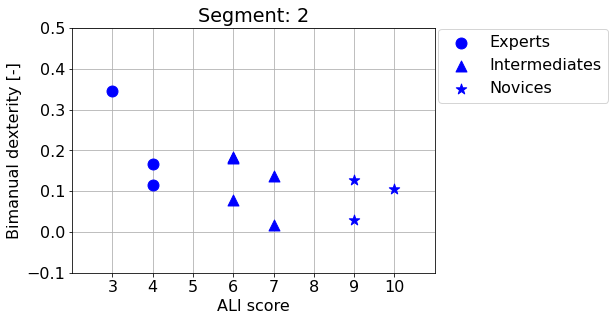

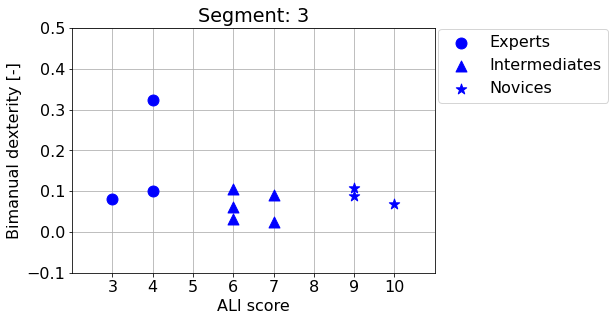

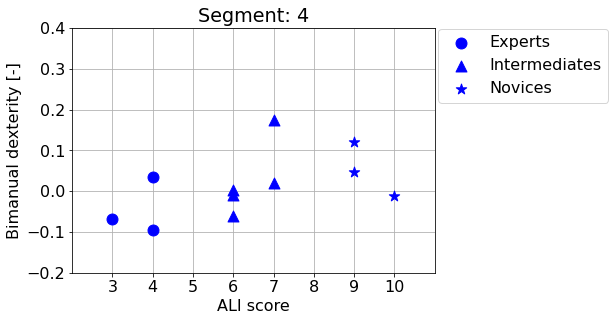

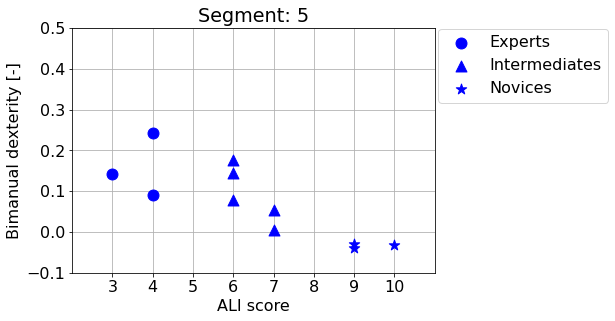

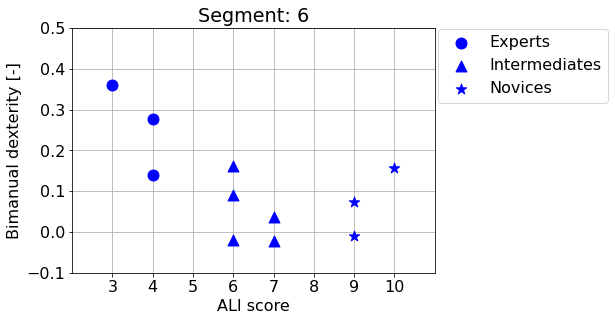

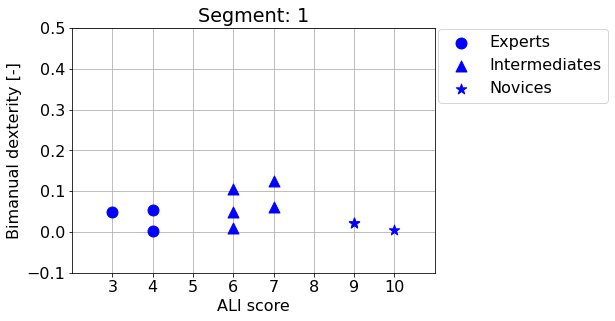

In [291]:

subject_order_novice = ['7','9','12']
ALI_novice = [9,9,10]
subject_order_intermediate = ['11','8','2','5','6']
ALI_intermediate = [6,6,6,7,7]
subject_order_expert = ['10','3','4']
ALI_expert = [3,4,4]

segment_new = [2,3,4,5,6,1]

for k, segment in enumerate(segment_list):
    y1 = []
    y2 = []
    y3 = []

    
    for subject in subject_order_expert:
        y1.append(mean_BD[subject][segment])
    for subject in subject_order_intermediate:
        y2.append(mean_BD[subject][segment])
    for subject in subject_order_novice:
        y3.append(mean_BD[subject][segment])     
    
    plt.figure(figsize=(6.5, 4.5))

    plt.scatter(ALI_expert, y1, s = 120 ,color='blue', marker = 'o', label ='Experts')
    plt.scatter(ALI_intermediate, y2, s = 120 ,color='blue', marker = '^', label = 'Intermediates')
    plt.scatter(ALI_novice, y3, s = 120 ,color='blue', marker = '*', label = 'Novices')


    plt.ylabel('Bimanual dexterity [-]')
    plt.xlabel('ALI score')
    plt.title('Segment: ' + str(segment_new[k]), fontdict=None, loc='center', pad=None)
    plt.grid()
    plt.legend(bbox_to_anchor=(1.5, 1.03))
    ticks = [3,4,5,6,7,8,9,10]
    
    plt.xlim([2, 11])
    if segment == "530":
        plt.ylim([-0.2, 0.4])
    else:
        if segment == "560":
            plt.ylim([-0.1, 0.5])
        else:
            plt.ylim([-0.1, 0.5])
                
    #plt.ylim([0, max(max(y1),max(y2),max(y3))+15])
    #plt.xticks(range(0, len(ticks) * 2, 2), ticks)
    plt.xticks(ticks=ticks, labels=ticks)
    
    plt.savefig(join('..', 'data_exp',  'PLOTS','optitrack_BD', 'BD_VS_ali_segment' + segment  +'.png'), bbox_inches='tight')
    #plt.savefig(join('..', 'data_exp',  'PLOTS','optitrack_BD','no_legend', 'BD_VS_ali_segment' + segment  +'.png'), bbox_inches='tight')


    plt.show()

## ANOVA BD

In [287]:
# create the data separating expertise for each channels
subject_order = ['10','3','4','8','11','2','5','6','7','9','12']
ALI_score = ['3','4','4','6','6','7','7','9','9','10']

novice_subjects = ['7','9','12']
intermediate_subjects = ['11','8','5','6','2']
expert_subjects = ['10','3','4']
category = ['Novice', 'Intermediate', 'Expert']



subject_expertise = {
    'Expert': expert_subjects,
    'Novice': novice_subjects,
    'Intermediate': intermediate_subjects
}


BD_segment_subject_expertise = {}
for segment in segment_list:
    BD_segment_subject_expertise[segment] = []

for segment in segment_list: 
    folder = join('..', 'data_exp' )
    rs_csv = join(folder,'ANOVA','optitrack','BD' + segment +'.csv')
    f = open(rs_csv, 'w') # open the file in the write mode                        
    # create the csv writer
    writer = csv.writer(f)
    header = ['category','value_BD']
    # write a row to the csv file
    writer.writerow(header)
    for cat in category:     
        for subject in subject_expertise[cat]:   
            for run in run_list[subject][segment]:
                BD_val = BD[subject][segment][run]
                
                row = [cat, BD_val]
                writer.writerow(row)
                BD_segment_subject_expertise[segment].append(row)
    f.close() 

    #met a la suite les valeurs des temps pour les runs des sujets avec la meme expertise, pour chaque segment
#print(time_segment_subject_expertise)

BD_expertise_dataframe = {}
for segment, values in BD_segment_subject_expertise.items():
    
    BD_expertise_dataframe[segment] = pd.DataFrame(values, columns=["category", "value_BD"])
#print( time_expertise_dataframe)
    
BD_anova_results = {}
for segment, dataframe in BD_expertise_dataframe.items():
    #perform one-way ANOVA
    model = ols('value_BD ~ C(category)', data=dataframe).fit()
    BD_anova_results[segment] = sm.stats.anova_lm(model, typ=2)
    print("segment: " + segment + " BD" )
    print(BD_anova_results[segment])
    print("\n")
print("-----------")
print("\n")





segment: 500 BD
               sum_sq    df         F    PR(>F)
C(category)  0.111795   2.0  2.589852  0.085937
Residual     0.992832  46.0       NaN       NaN


segment: 510 BD
               sum_sq    df         F    PR(>F)
C(category)  0.103555   2.0  4.882091  0.011845
Residual     0.498464  47.0       NaN       NaN


segment: 530 BD
               sum_sq    df         F    PR(>F)
C(category)  0.079971   2.0  1.905854  0.160011
Residual     0.986079  47.0       NaN       NaN


segment: 540 BD
               sum_sq    df         F    PR(>F)
C(category)  0.256458   2.0  9.693188  0.000316
Residual     0.595295  45.0       NaN       NaN


segment: 541 BD
               sum_sq    df          F    PR(>F)
C(category)  0.438054   2.0  10.277236  0.000204
Residual     0.980346  46.0        NaN       NaN


segment: 560 BD
               sum_sq    df         F    PR(>F)
C(category)  0.019587   2.0  2.725743  0.076562
Residual     0.158088  44.0       NaN       NaN


-----------




In [277]:
print(segment_list_optitrack)
print(segment_new_optitrack)

['500', '510', '530', '540', '541']
['2', '3', '4', '5', '6']
